### Imports:

In [1]:
import numpy as np
import pandas as pd
import SimpleITK as sitk
import os
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
import matplotlib.image as mpimg
from scipy import ndimage
from scipy.stats import gaussian_kde
import seaborn as sns
from skimage import morphology
import tensorflow as tf
from tensorflow.keras.utils import Sequence
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
from Models.MedicalNet.models import resnet  # from MedicalNet/models/resnet.py
import torch.optim as optim

import gdown
gdown.download(
    'https://drive.google.com/uc?id=1DoDx_70_TLj98gTf6YTXnu4tFhsFocDX',
    'Models/Weights/medicalnet_resnet.pth',
    quiet=False
)
%matplotlib widget

Downloading...
From (original): https://drive.google.com/uc?id=1DoDx_70_TLj98gTf6YTXnu4tFhsFocDX
From (redirected): https://drive.google.com/uc?id=1DoDx_70_TLj98gTf6YTXnu4tFhsFocDX&confirm=t&uuid=94e0ffb7-d9f5-4543-9d84-b75df8a963b4
To: d:\4DS7\PIDS\Models\Weights\medicalnet_resnet.pth
100%|██████████| 111M/111M [01:45<00:00, 1.06MB/s] 


### Reading Data:

In [2]:
def load_itk_image(filename):
    itkimage = sitk.ReadImage(filename)

    numpyImage = sitk.GetArrayFromImage(itkimage)
    numpyOrigin = np.array(list(reversed(itkimage.GetOrigin())))
    numpySpacing = np.array(list(reversed(itkimage.GetSpacing())))

    return numpyImage, numpyOrigin, numpySpacing

def read_luna_dataset(root_dir):
    Dataset={}
    subsets = [d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))]
    print(subsets)

    for subset in subsets:
        mhd_files = [f for f in os.listdir(os.path.join(root_dir, subset)) if f.endswith(".mhd")]
        if subset not in Dataset:
            Dataset[subset] = {}

        for index, file in enumerate(mhd_files):
            Dataset[subset][f"CT_{index}"] = file

    return Dataset


In [3]:
if __name__ == "__main__":
    Data = read_luna_dataset("Data/Luna")

['input', 'subset0', 'subset1', 'subset10', 'subset2', 'subset3', 'subset4', 'subset5', 'subset6', 'subset7', 'subset8', 'subset9']


In [4]:
if __name__ == "__main__":
    for key, value in Data.items():
        for key_, value_ in value.items():
            if value_ == "1.3.6.1.4.1.14519.5.2.1.6279.6001.169128136262002764211589185953.mhd":
                print(key, key_)

subset1 CT_25


In [5]:
def load_csv(filename):
    return pd.read_csv(f"Data/Luna/{filename}")

In [6]:
if __name__ == "__main__":
    patients_count = 0
    for key, value in Data.items():
        patients_count += len(value)

In [7]:
def basic_statistics(data):
    print("Infos:\n", data.info())
    print("Description:\n", data.describe())
    print("Presence of null values:\n")
    print(data.isnull().sum())

In [8]:
if __name__ == "__main__":
    annotations = load_csv("annotations.csv")
    basic_statistics(annotations)
    

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1186 entries, 0 to 1185
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   seriesuid    1186 non-null   object 
 1   coordX       1186 non-null   float64
 2   coordY       1186 non-null   float64
 3   coordZ       1186 non-null   float64
 4   diameter_mm  1186 non-null   float64
dtypes: float64(4), object(1)
memory usage: 46.5+ KB
Infos:
 None
Description:
             coordX       coordY       coordZ  diameter_mm
count  1186.000000  1186.000000  1186.000000  1186.000000
mean     -5.067547     8.428113  -160.159029     8.306527
std      84.468115    98.316003   279.829437     4.762033
min    -164.351031  -283.834336  -790.074799     3.253443
25%     -80.909225   -51.549643  -221.197808     5.107177
50%     -32.855132    18.787926  -167.615160     6.433600
75%      76.830069    67.245915  -109.735281     9.696301
max     164.763985   271.405521  1790.494057    32.27003

The number of patients who have nodules: 601
1186


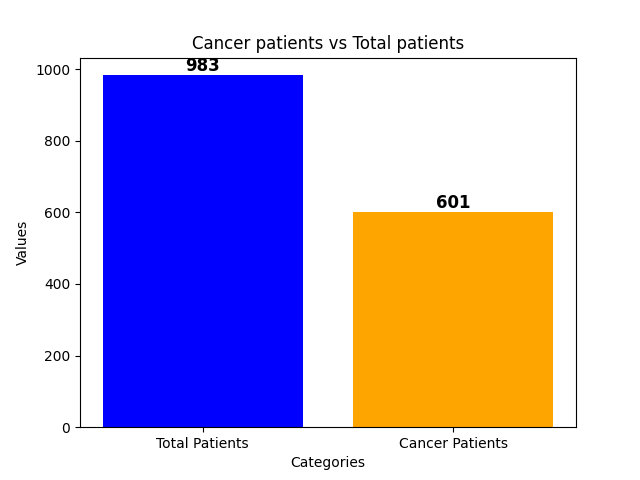

In [9]:
if __name__ == "__main__":
    print(f"The number of patients who have nodules: {annotations['seriesuid'].nunique()}")
    print(annotations["seriesuid"].count())

    total_cancer_patients = annotations['seriesuid'].nunique()
    categories = ["Total Patients", "Cancer Patients"]
    values = [patients_count, total_cancer_patients]

    # Create bar plot
    fig, ax = plt.subplots()
    bars = ax.bar(categories, values, color=['blue', 'orange'])

    # Add values on top of the bars
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, height, str(height), ha='center', va='bottom', fontsize=12, fontweight='bold')

    # Labels and title
    plt.xlabel('Categories')
    plt.ylabel('Values')
    plt.title('Cancer patients vs Total patients')

    plt.savefig('Data_vis/bar_plot.png', dpi=300, bbox_inches='tight')

    # Show plot
    plt.show()

### Visualize the distribution of nodules on the lungs:

In [10]:
def scatter_2d(data, axis1="coordX", axis2="coordY"):
    """
    Create a 2D scatter plot using selected axes.
    
    Parameters:
    - data: Pandas DataFrame containing 'coordX', 'coordY', and 'coordZ'.
    - axis1: The first coordinate for the x-axis (default: 'coordX').
    - axis2: The second coordinate for the y-axis (default: 'coordY').
    """
    x = data[axis1]
    y = data[axis2]

    # Compute point density
    xy = np.vstack([x, y])
    density = gaussian_kde(xy)(xy)  # Kernel Density Estimation

    # Sort by density so that dense points appear on top
    idx = density.argsort()
    x, y, density = x[idx], y[idx], density[idx]

    plt.figure(figsize=(8, 6))
    plt.scatter(x, y, c=density, cmap="plasma", s=10, alpha=0.75)

    # Labels
    plt.xlabel(axis1)
    plt.ylabel(axis2)
    plt.title(f"2D Scatter Plot ({axis1} vs {axis2}) with Density Coloring")
    plt.colorbar(label="Density")  # Add a color legend

    plt.savefig('Data_vis/Nodule distribution 2d.png', dpi=300, bbox_inches='tight')

    plt.show()

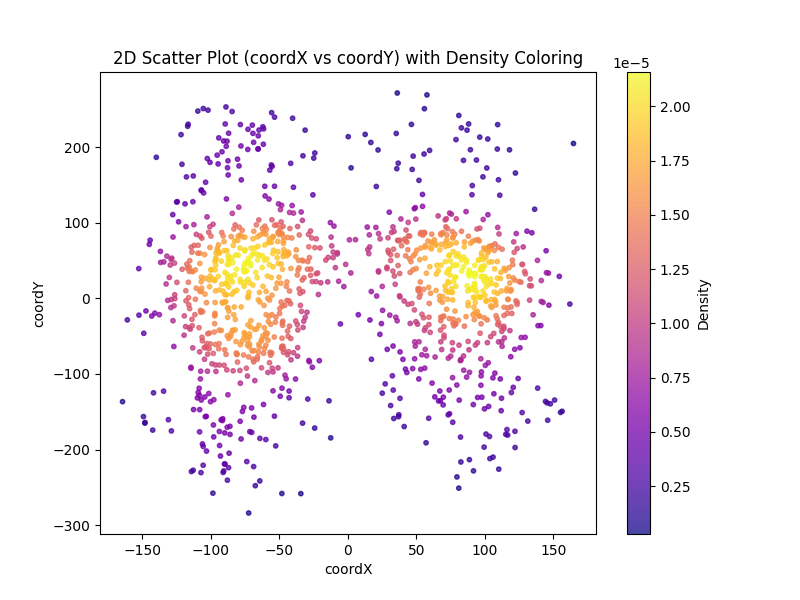

In [11]:
if __name__ == "__main__":
    scatter_2d(annotations)

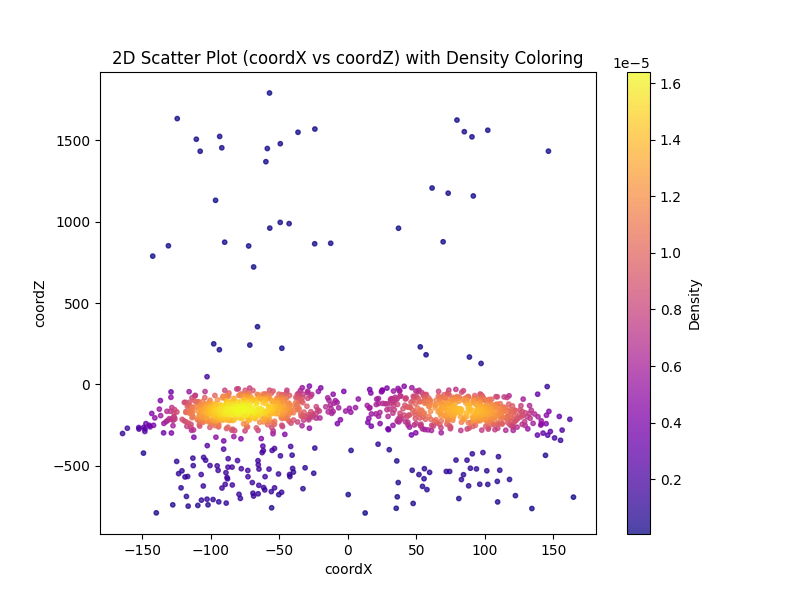

In [12]:
if __name__ == "__main__":
    scatter_2d(annotations, axis2="coordZ")

In [13]:
def scatter_3d(data):
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(data["coordX"], data["coordY"], data["coordZ"], c='blue', alpha=0.5)
    
    ax.set_xlabel("X Coordinate")
    ax.set_ylabel("Y Coordinate")
    ax.set_zlabel("Z Coordinate")
    ax.set_title("3D Scatter Plot of Nodule Locations")

    plt.savefig('Data_vis/Luna/3d_scatter.png', dpi=300, bbox_inches='tight')

    plt.show()


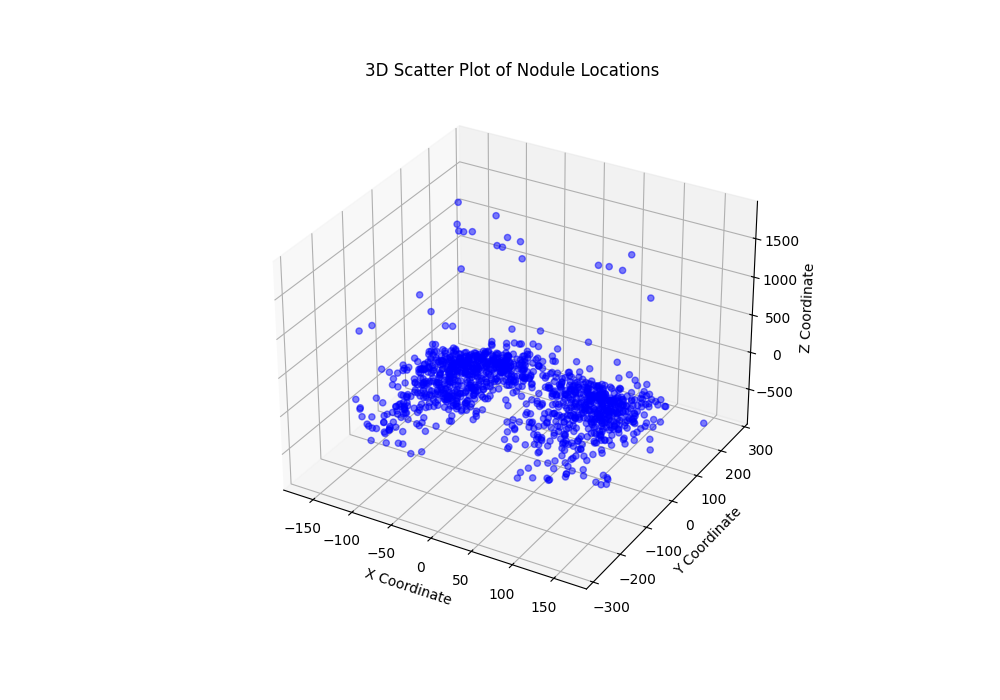

In [14]:
if __name__ == "__main__":
    scatter_3d(annotations)

### Nodule size distribution:

In [15]:
def diameters_hist(data):
    plt.figure(figsize=(8, 5))
    plt.hist(data["diameter_mm"], bins=30, color="skyblue", edgecolor="black")
    plt.xlabel("Diameter (mm)")
    plt.ylabel("Frequency")
    plt.title("Distribution of Nodule Diameters")

    plt.savefig('Data_vis/Luna/Nodule size distribution.png', dpi=300, bbox_inches='tight')

    plt.show()


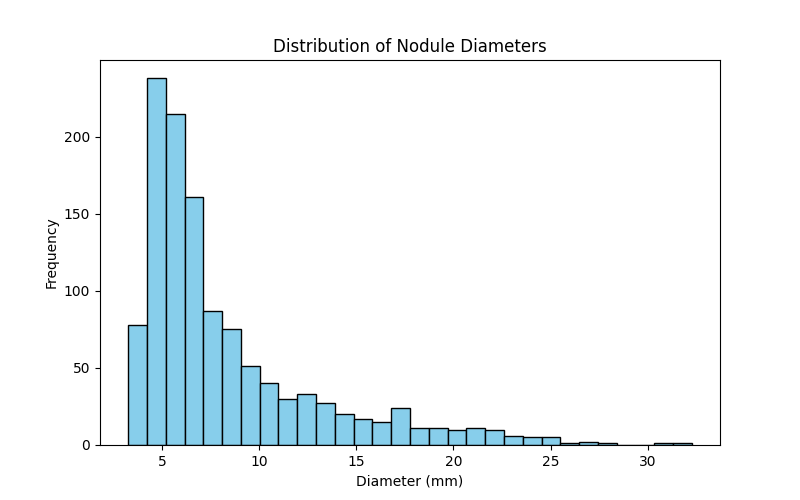

In [16]:
if __name__ == "__main__":
    diameters_hist(annotations)

In [17]:
def boxplot_nodule_size(data):
    plt.figure(figsize=(6, 4))
    sns.boxplot(x=data["diameter_mm"], color="lightblue")
    plt.xlabel("Nodule Diameter (mm)")
    plt.title("Boxplot of Nodule Sizes")

    plt.savefig('Data_vis/Luna/Nodule size box-plot.png', dpi=300, bbox_inches='tight')

    plt.show()

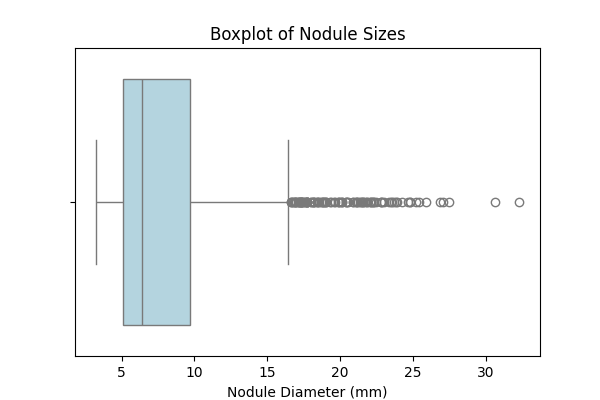

In [18]:
if __name__ == "__main__":
    boxplot_nodule_size(annotations)

In [19]:
def pairplot_annotations(data):
    import seaborn as sns
    sns.pairplot(data, diag_kind="kde", corner=True)
    plt.suptitle("Pairplot of Nodule Features", y=1.02)

    plt.savefig('Data_vis/Luna/Pai_plot.png', dpi=300, bbox_inches='tight')

    plt.show()

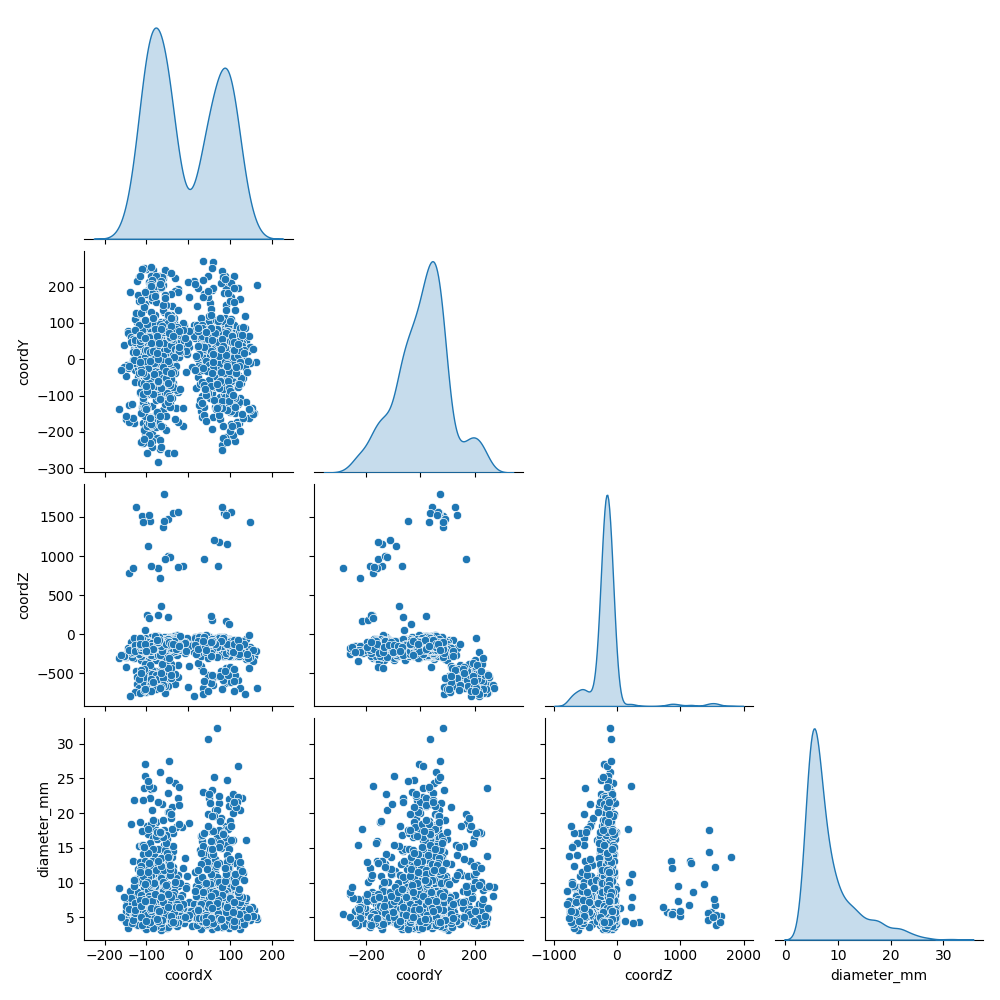

In [20]:
if __name__ == "__main__":
    pairplot_annotations(annotations)

### Visualizing the CT-scans:

In [21]:
def visualize_single_slice(volumeImage, plot_name, slice, x=None, y=None):
    """
    Visualizes a single slice from a volume image.
    
    Parameters:
        volumeImage (ndarray): 3D volume data.
        slice (int): Index of the slice to visualize.
        x (float or int, optional): X-coordinate for the red dot.
        y (float or int, optional): Y-coordinate for the red dot.
    """
    # Create figure and adjust layout to make room for slider if needed
    fig, ax = plt.subplots(figsize=(8, 8))

    # Display the slice (CT scan) in grayscale
    im = ax.imshow(volumeImage[slice], cmap="gray")
    ax.set_title(f"CT Scan Slice {slice}")
    ax.axis("off")
    
    # If both x and y coordinates are provided, plot a red dot
    if x is not None and y is not None:
        ax.plot(x, y, 'ro', markersize=3)  # 'ro' means red circle marker
        # Optionally, add a label or annotation if needed
        ax.annotate("({},{})".format(x, y), (x, y), color="red", fontsize=10, xytext=(5, 5), textcoords="offset points")

    plt.savefig(f'Data_vis/Luna/{plot_name}', dpi=300, bbox_inches='tight')

    plt.show()


In [22]:
def visualize_image(volumeImage):
    # Create figure and adjust layout to make room for slider
    fig, (ax, ax_xray) = plt.subplots(1, 2, figsize=(16, 8))
    plt.subplots_adjust( right=0.8)

    # Initialize slice (middle slice)
    initial_slice = volumeImage.shape[0] // 2
    current_slice = initial_slice

    # Display initial slice (CT scan) on the left side
    im = ax.imshow(volumeImage[initial_slice], cmap="gray")
    ax.set_title(f"CT Scan Slice {initial_slice}")
    ax.axis("off")

    # Load your chest X-ray image
    xray_image_path = "Assets/chest.jpg"  # Replace with your actual chest X-ray image path
    xray_image = mpimg.imread(xray_image_path)
    height, width = xray_image.shape[:2]
    initial_line_h = height // 2 
    slices_nbr = volumeImage.shape[0] - 1
    line_slices = np.linspace(0, height, slices_nbr)

    # Set up X-ray image on the right side
    xray_im = ax_xray.imshow(xray_image, cmap="gray")
    ax_xray.set_title("Chest X-Ray")
    ax_xray.axis("off")
    
    # Add a horizontal line on the X-ray image indicating the current slice
    line = ax_xray.axhline(y=line_slices[current_slice], color="red", linestyle="--", linewidth=2)

    # Create vertical slider on the left side
    ax_slider = plt.axes([0.85, 0.26, 0.03, 0.47])  # [left, bottom, width, height]
    slice_slider = Slider(
        ax=ax_slider, 
        label="Slice Number", 
        valmin=1, 
        valmax=volumeImage.shape[0] - 1, 
        valinit=initial_slice, 
        valstep=1,
        orientation="vertical"
    )

    # Update function for slider
    def update(val):
        current_slice = int(slice_slider.val)
        im.set_data(volumeImage[current_slice])  # Update CT slice
        ax.set_title(f"CT Scan Slice {current_slice}")
        idx = int(slices_nbr - val+1)
        line.set_ydata([line_slices[idx]])  # Update the position of the horizontal line on the X-ray
        fig.canvas.draw_idle()

    # Register update function with slider
    slice_slider.on_changed(update)

    # Show the plot
    plt.show()

In [23]:
def visualize_image_bb(volumeImage, bbox_df):
    fig, (ax, ax_xray) = plt.subplots(1, 2, figsize=(16, 8))
    plt.subplots_adjust(right=0.8)

    initial_slice = volumeImage.shape[0] // 2
    current_slice = initial_slice

    # Display initial CT slice
    im = ax.imshow(volumeImage[initial_slice], cmap="gray")
    ax.set_title(f"CT Scan Slice {initial_slice}")
    ax.axis("off")

    # Load X-ray image
    xray_image_path = "Assets/chest.jpg"  # Replace with actual path
    xray_image = mpimg.imread(xray_image_path)
    height, width = xray_image.shape[:2]
    slices_nbr = volumeImage.shape[0] - 1
    line_slices = np.linspace(0, height, slices_nbr)

    xray_im = ax_xray.imshow(xray_image, cmap="gray")
    ax_xray.set_title("Chest X-Ray")
    ax_xray.axis("off")
    
    line = ax_xray.axhline(y=line_slices[current_slice], color="red", linestyle="--", linewidth=2)
    
    # Convert DataFrame to list of bounding boxes
    bbox_list = []
    for _, row in bbox_df.iterrows():
        x, y, z, h = row["bbox_x"], row["bbox_y"], row["bbox_z"], row["diameter_mm"]
        bbox_list.append((x, y, int(z), int(h)))  # Convert z and h to integers

    # Store rectangles for each bounding box
    rects = []
    for bbox in bbox_list:
        x, y, z, h = bbox
        if z <= initial_slice <= z + h:
            rect = plt.Rectangle((x, y), h, h, linewidth=1, edgecolor='r', facecolor='none')
            ax.add_patch(rect)
            rects.append(rect)
        else:
            rects.append(None)
    
    ax_slider = plt.axes([0.85, 0.26, 0.03, 0.47])
    slice_slider = Slider(
        ax=ax_slider, 
        label="Slice", 
        valmin=0,  # Adjusted to start from 0
        valmax=volumeImage.shape[0] - 1, 
        valinit=initial_slice, 
        valstep=1,
        orientation="vertical"
    )

    def update(val):
        nonlocal current_slice, rects
        current_slice = int(slice_slider.val)
        im.set_data(volumeImage[current_slice])
        ax.set_title(f"CT Scan Slice {current_slice}")
        idx = int(slices_nbr - val + 1)
        line.set_ydata([line_slices[idx]])
        
        # Update bounding boxes visibility
        for i, bbox in enumerate(bbox_list):
            x, y, z, h = bbox
            if rects[i]:
                rects[i].remove()  # Remove the old rectangle
            if z <= current_slice <= z + h:
                rects[i] = plt.Rectangle((x, y), h, h, linewidth=2, edgecolor='r', facecolor='none')
                ax.add_patch(rects[i])
            else:
                rects[i] = None
        
        fig.canvas.draw_idle()

    slice_slider.on_changed(update)
    plt.show()

In [24]:
if __name__ == "__main__":
    numpyImage, numpyOrigin, numpySpacing = load_itk_image(os.path.join("Data/Luna/subset1", "1.3.6.1.4.1.14519.5.2.1.6279.6001.169128136262002764211589185953.mhd"))

In [25]:
print("Min value:", numpyImage.min())
print("Max value:", numpyImage.max())

Min value: -3024
Max value: 3071


In [26]:
print(numpySpacing)

[1.25       0.74218798 0.74218798]


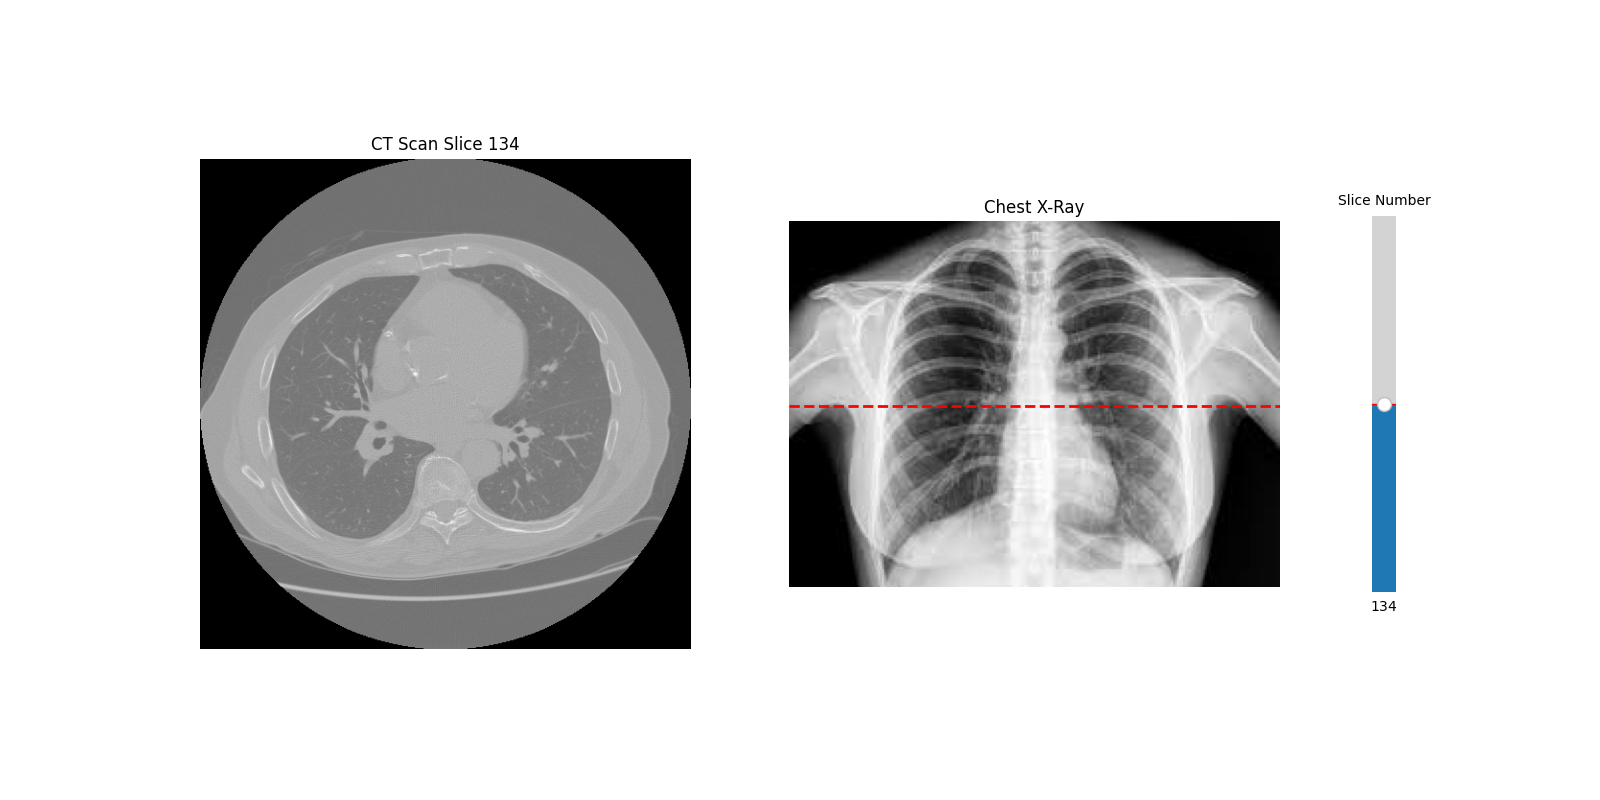

In [27]:
if __name__ == "__main__":
    visualize_image(numpyImage)

# Data Preprocessing:

### Resize the CT-scans to the same size [1, 1, 1] spacing: (using Interpolation)

In [28]:
if __name__ == "__main__":
    print(numpyImage.shape)
    print(numpyOrigin)
    print(numpySpacing)

(268, 512, 512)
[-338.984985 -203.5      -169.199997]
[1.25       0.74218798 0.74218798]


In [29]:
def convert_world_to_voxel_coord(seriesuid, numpyOrigin, numpySpacing, annotations):
    """
    Convert world coordinates to voxel coordinates for a specific seriesuid.
    
    Parameters:
        seriesuid (str): The seriesuid to filter annotations.
        numpyOrigin (np.array): Origin of the CT scan in world coordinates.
        numpySpacing (np.array): Spacing of the CT scan voxels.
        annotations (pd.DataFrame or pd.Series): DataFrame or Series containing annotations with world coordinates.
    
    Returns:
        pd.DataFrame: Filtered annotations with voxel coordinates.
    """
    # Check if annotations is a Series and convert it to a DataFrame if necessary
    if isinstance(annotations, pd.Series):
        annotations = annotations.to_frame().T  # Convert Series to DataFrame

    # Ensure annotations is a DataFrame
    if not isinstance(annotations, pd.DataFrame):
        raise ValueError("annotations must be a pandas DataFrame or Series.")
    # Filter the annotations for the specific seriesuid
    mask = annotations["seriesuid"] == seriesuid
    filtered_annotations = annotations[mask].copy()  # Create a copy to avoid modifying the original
    
    # Convert world coordinates to voxel coordinates
    filtered_annotations.loc[:, "coordZ"] = np.round((filtered_annotations.loc[:, "coordZ"] - numpyOrigin[0]) / numpySpacing[0]).astype(int)
    filtered_annotations.loc[:, "coordY"] = np.round((filtered_annotations.loc[:, "coordY"] - numpyOrigin[1]) / numpySpacing[1]).astype(int)
    filtered_annotations.loc[:, "coordX"] = np.round((filtered_annotations.loc[:, "coordX"] - numpyOrigin[2]) / numpySpacing[2]).astype(int)
    
    return filtered_annotations

In [30]:
def convert_world_to_voxel_coord_bbox(seriesuid, numpyOrigin, numpySpacing, annotations):
    # Filter the annotations for the specific seriesuid
    mask = annotations["seriesuid"] == seriesuid
    filtered_annotations = annotations[mask].copy()  # Create a copy to avoid modifying the original
    
    # Convert world coordinates to voxel coordinates
    filtered_annotations.loc[:, "coordZ"] = np.round((filtered_annotations.loc[:, "coordZ"] - numpyOrigin[0]) / numpySpacing[0]).astype(int)
    filtered_annotations.loc[:, "coordY"] = np.round((filtered_annotations.loc[:, "coordY"] - numpyOrigin[1]) / numpySpacing[1]).astype(int)
    filtered_annotations.loc[:, "coordX"] = np.round((filtered_annotations.loc[:, "coordX"] - numpyOrigin[2]) / numpySpacing[2]).astype(int)
    filtered_annotations.loc[:, "bbox_z"] = np.round((filtered_annotations.loc[:, "bbox_z"] - numpyOrigin[0]) / numpySpacing[0]).astype(int)
    filtered_annotations.loc[:, "bbox_y"] = np.round((filtered_annotations.loc[:, "bbox_y"] - numpyOrigin[1]) / numpySpacing[1]).astype(int)
    filtered_annotations.loc[:, "bbox_x"] = np.round((filtered_annotations.loc[:, "bbox_x"] - numpyOrigin[2]) / numpySpacing[2]).astype(int)
    
    return filtered_annotations

In [31]:
if __name__ == "__main__":
    annotations = load_csv("annotations.csv")
    annotations_bbox = load_csv("annotations_bbox.csv")

In [32]:
def resize_image_with_annotation(seriesuid, numpyImage, numpyOrigin, numpySpacing, annotations):
    newAnnotations = convert_world_to_voxel_coord(seriesuid, numpyOrigin, numpySpacing, annotations)
    RESIZE_SPACING = [1.0, 1.0, 1.0]
    resize_factor = numpySpacing / RESIZE_SPACING

    new_real_shape = numpyImage.shape * resize_factor
    new_shape = np.round(new_real_shape)

    real_resize = new_shape / numpyImage.shape

    new_volume = ndimage.zoom(numpyImage, zoom=real_resize)

    newOrigin = numpyOrigin * (RESIZE_SPACING / numpySpacing)

    newAnnotations.loc[:, "coordX"] = (newAnnotations.loc[:, "coordX"] * resize_factor[2]).round().astype(int)
    newAnnotations.loc[:, "coordY"] = (newAnnotations.loc[:, "coordY"] * resize_factor[1]).round().astype(int)
    newAnnotations.loc[:, "coordZ"] = (newAnnotations.loc[:, "coordZ"] * resize_factor[0]).round().astype(int)
    
    return new_volume, newOrigin, RESIZE_SPACING, newAnnotations

In [33]:
def resize_image_with_annotation_bbox(seriesuid, numpyImage, numpyOrigin, numpySpacing, annotations):
    newAnnotations = convert_world_to_voxel_coord_bbox(seriesuid, numpyOrigin, numpySpacing, annotations)
    RESIZE_SPACING = [1.0, 1.0, 1.0]
    resize_factor = numpySpacing / RESIZE_SPACING

    new_real_shape = numpyImage.shape * resize_factor
    new_shape = np.round(new_real_shape)

    real_resize = new_shape / numpyImage.shape

    new_volume = ndimage.zoom(numpyImage, zoom=real_resize)

    newOrigin = numpyOrigin * (RESIZE_SPACING / numpySpacing)

    newAnnotations.loc[:, "coordX"] = (newAnnotations.loc[:, "coordX"] * resize_factor[2]).round().astype(int)
    newAnnotations.loc[:, "coordY"] = (newAnnotations.loc[:, "coordY"] * resize_factor[1]).round().astype(int)
    newAnnotations.loc[:, "coordZ"] = (newAnnotations.loc[:, "coordZ"] * resize_factor[0]).round().astype(int)
    newAnnotations.loc[:, "bbox_x"] = (newAnnotations.loc[:, "bbox_x"] * resize_factor[2]).round().astype(int)
    newAnnotations.loc[:, "bbox_y"] = (newAnnotations.loc[:, "bbox_y"] * resize_factor[1]).round().astype(int)
    newAnnotations.loc[:, "bbox_z"] = (newAnnotations.loc[:, "bbox_z"] * resize_factor[0]).round().astype(int)

    
    return new_volume, newOrigin, RESIZE_SPACING, newAnnotations

In [34]:
if __name__ == "__main__":
    annotations = load_csv("annotations.csv")

In [35]:
if __name__ == "__main__":
    resizedNumpyImage, newOrignn, newSpacing, resizedAnn = resize_image_with_annotation("1.3.6.1.4.1.14519.5.2.1.6279.6001.169128136262002764211589185953", numpyImage, numpyOrigin, numpySpacing, annotations)

In [36]:
if __name__ == "__main__":
    print(resizedNumpyImage.shape)
    print(newOrignn)
    print(newSpacing)

(335, 380, 380)
[-271.187988   -274.18929752 -227.97458633]
[1.0, 1.0, 1.0]


In [37]:
if __name__ == "__main__":
    print(resizedAnn["seriesuid"].iloc[0])
    print(resizedAnn)

1.3.6.1.4.1.14519.5.2.1.6279.6001.169128136262002764211589185953
                                             seriesuid  coordX  coordY  \
248  1.3.6.1.4.1.14519.5.2.1.6279.6001.169128136262...   221.0   216.0   
249  1.3.6.1.4.1.14519.5.2.1.6279.6001.169128136262...   295.0   225.0   
250  1.3.6.1.4.1.14519.5.2.1.6279.6001.169128136262...    94.0   241.0   
251  1.3.6.1.4.1.14519.5.2.1.6279.6001.169128136262...   246.0   171.0   
252  1.3.6.1.4.1.14519.5.2.1.6279.6001.169128136262...   118.0   257.0   
253  1.3.6.1.4.1.14519.5.2.1.6279.6001.169128136262...   142.0   234.0   
254  1.3.6.1.4.1.14519.5.2.1.6279.6001.169128136262...   331.0   196.0   

     coordZ  diameter_mm  
248   302.0    21.475613  
249   209.0     6.661547  
250    96.0     6.463901  
251   259.0     5.233377  
252   255.0     4.500244  
253   265.0     3.813183  
254   125.0     4.994599  


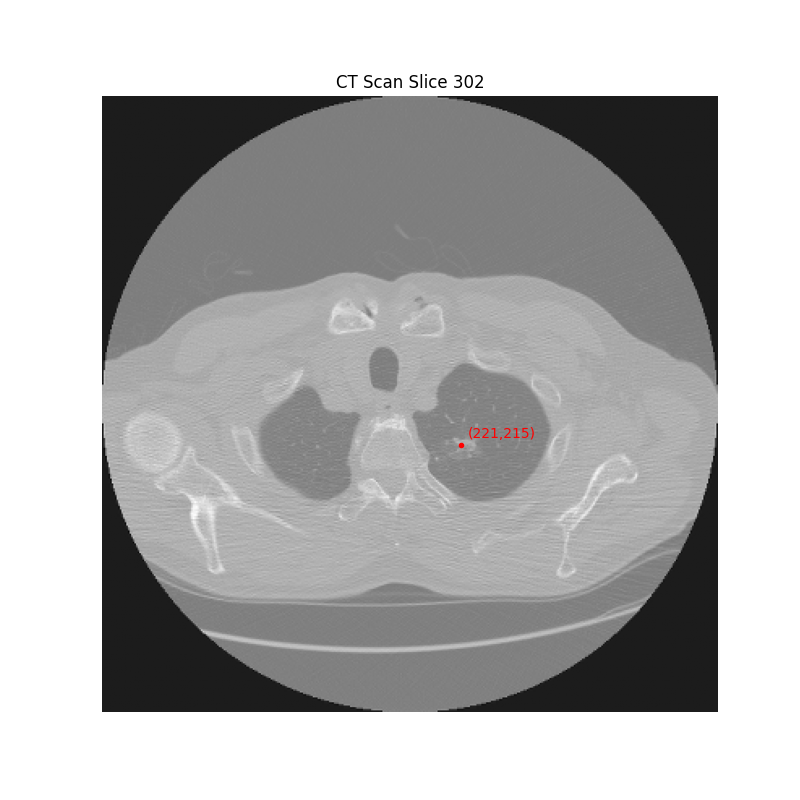

In [38]:
visualize_single_slice(resizedNumpyImage, "Nodule vis", 302, 221, 215)

### Resizing with bbox:

In [39]:
if __name__ == "__main__":
    annotations_bbox = load_csv("annotations_bbox.csv")

In [40]:
if __name__ == "__main__":
    resizedNumpyImage, newOrignn, newSpacing, resizedAnn = resize_image_with_annotation_bbox("1.3.6.1.4.1.14519.5.2.1.6279.6001.169128136262002764211589185953", numpyImage, numpyOrigin, numpySpacing, annotations_bbox)

In [41]:
resizedAnn

seriesuid  coordX  coordY  \
248  1.3.6.1.4.1.14519.5.2.1.6279.6001.169128136262...   221.0   216.0   
249  1.3.6.1.4.1.14519.5.2.1.6279.6001.169128136262...   295.0   225.0   
250  1.3.6.1.4.1.14519.5.2.1.6279.6001.169128136262...    94.0   241.0   
251  1.3.6.1.4.1.14519.5.2.1.6279.6001.169128136262...   246.0   171.0   
252  1.3.6.1.4.1.14519.5.2.1.6279.6001.169128136262...   118.0   257.0   
253  1.3.6.1.4.1.14519.5.2.1.6279.6001.169128136262...   142.0   234.0   
254  1.3.6.1.4.1.14519.5.2.1.6279.6001.169128136262...   331.0   196.0   

     coordZ  diameter_mm  bbox_x  bbox_y  bbox_z  
248   302.0    21.475613   211.0   206.0   292.0  
249   209.0     6.661547   292.0   221.0   205.0  
250    96.0     6.463901    90.0   238.0    94.0  
251   259.0     5.233377   243.0   168.0   256.0  
252   255.0     4.500244   116.0   255.0   252.0  
253   265.0     3.813183   140.0   232.0   262.0  
254   125.0     4.994599   329.0   194.0   122.0

In [42]:
if __name__ == "__main__":
    print(resizedAnn["bbox_x"].iloc[0], resizedAnn["bbox_y"].iloc[0], resizedAnn["bbox_z"].iloc[0], resizedAnn["diameter_mm"].iloc[0].round().astype(int))

211.0 206.0 292.0 21


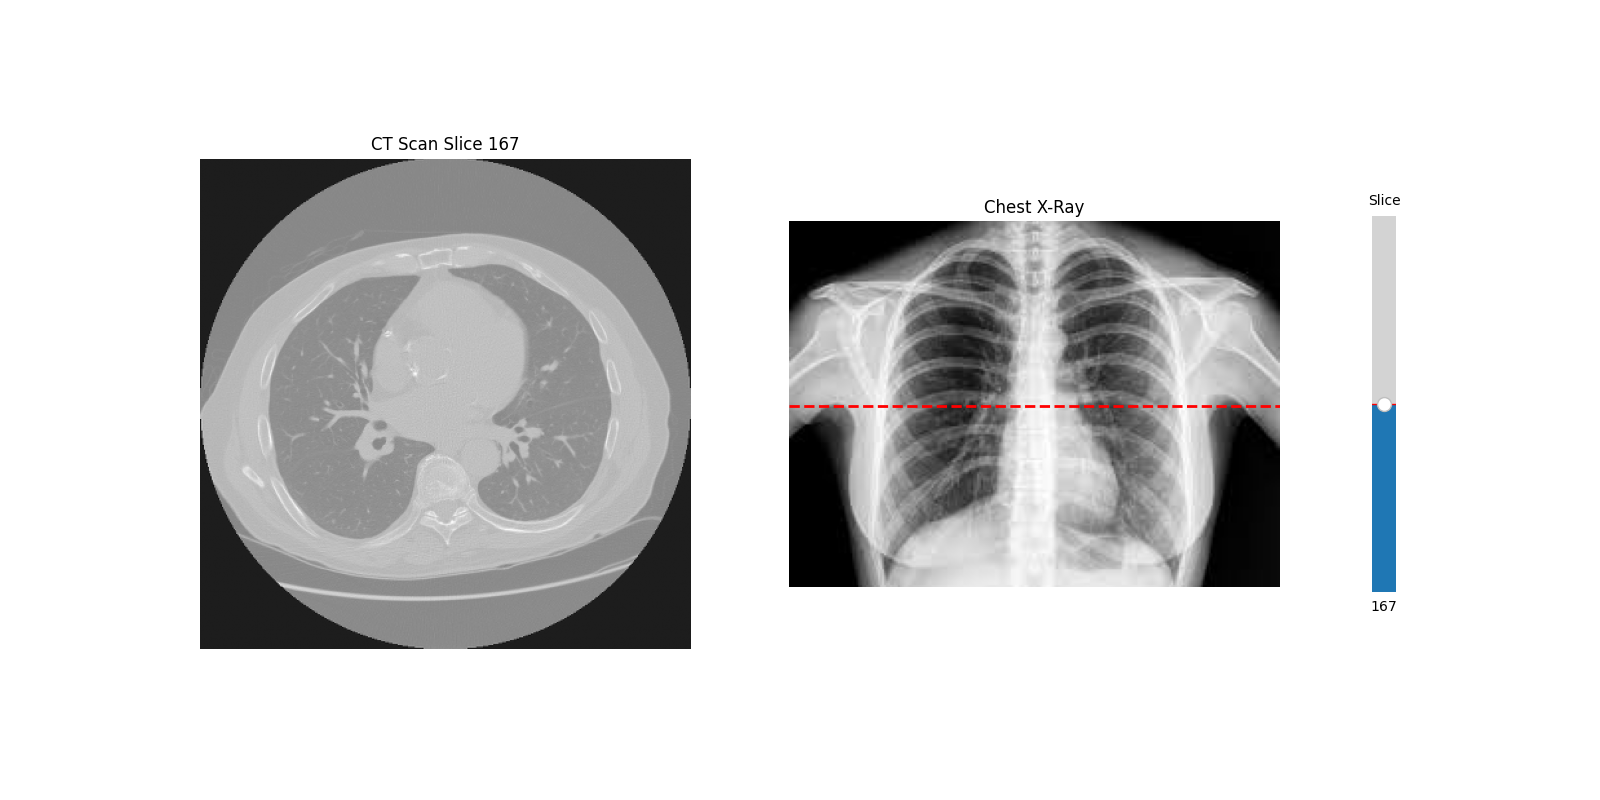

In [43]:
visualize_image_bb(resizedNumpyImage, resizedAnn)

### Removing Outliers: Clipping to HU values [-1000(air), 600(soft tissue)]:

In [44]:
def clip_CT_scan(numpyImage):
    return np.clip(numpyImage, -1200, 600)

In [45]:
if __name__ == "__main__":
    newImage =  clip_CT_scan(resizedNumpyImage)

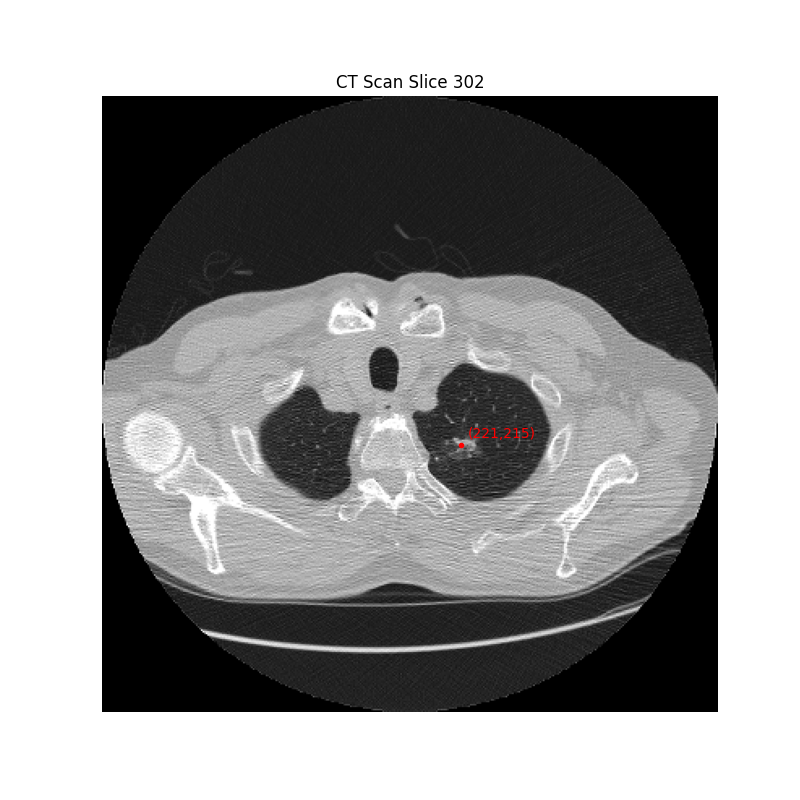

In [46]:
visualize_single_slice(newImage, "After removing outliers", 302, 221, 215)

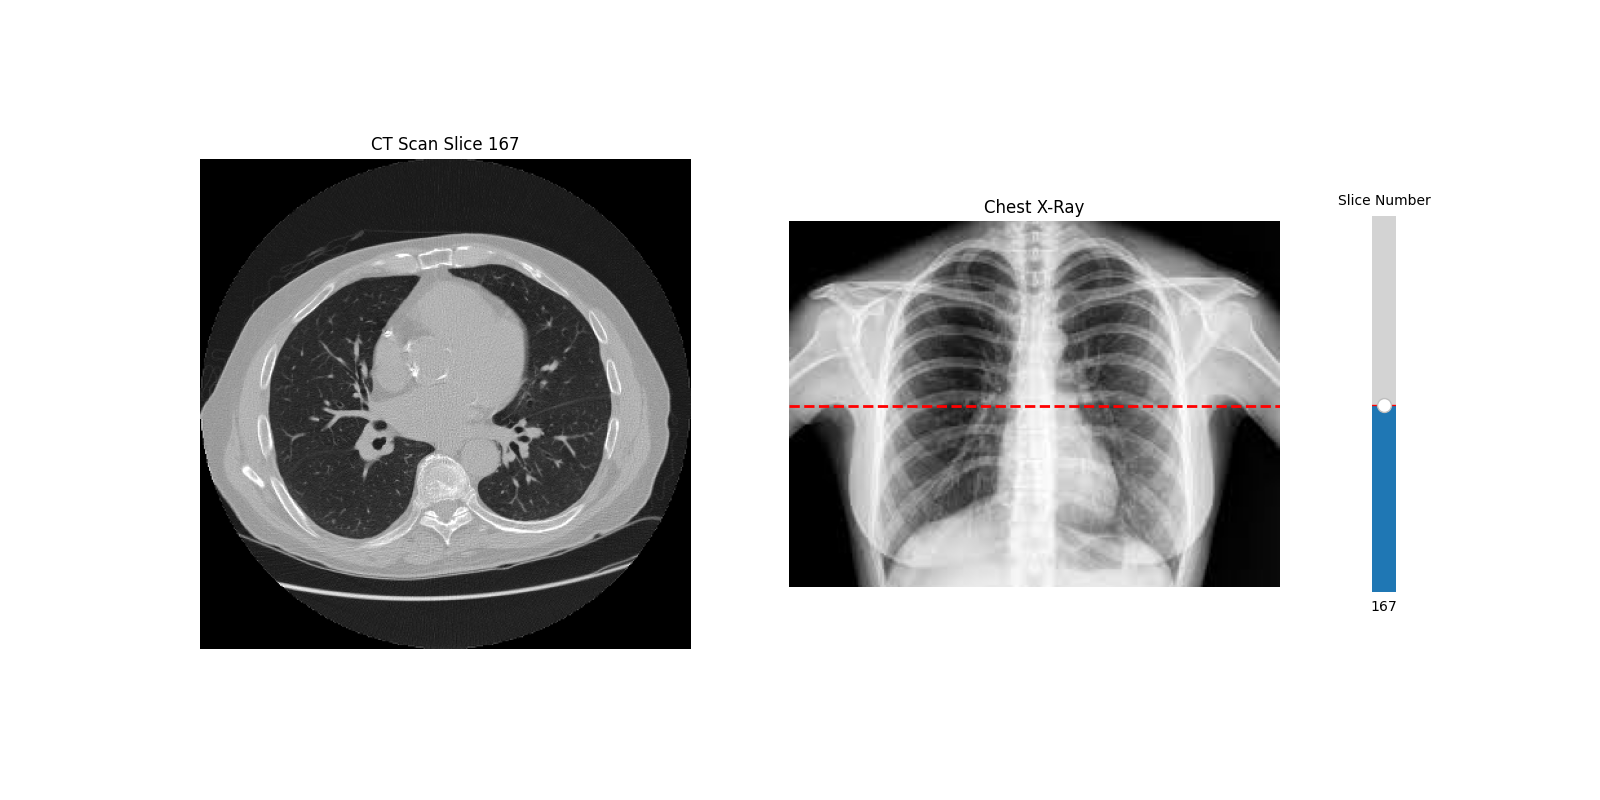

In [47]:
if __name__ == "__main__":
    visualize_image(newImage)

### Isolating the Lung region from other parts:

In [48]:
def threshHold_segmentation(numpyImage, lower=-1000, upper=-600):
    """
    Segment the lung region using thresholding.
    Args:
        numpyImage: Input image in Hounsfield Units (HU).
        lower: Lower Hounsfield value
        upp: Upper Hounsfield value
    Returns:
        Binary mask of the slected region.
    """
    mask = np.logical_and(numpyImage >= lower, numpyImage <= upper)

    return mask

def get_lung_mask(numpyImage):
    # Get the lung region
    lung_mask = threshHold_segmentation(numpyImage)

    # Post process the lung mask (remove holes/smooth boundaries)
    lung_mask = morphology.binary_closing(lung_mask, morphology.ball(5))
    lung_mask = morphology.binary_opening(lung_mask, morphology.ball(5))
    lung_mask = morphology.binary_dilation(lung_mask, morphology.ball(2))

    return lung_mask

def refine_nodule_masks(
        numpyImage, 
        lung_mask, 
        nodule_ranges= [
            (-1200, -600),  # Lung tissue
            (-600, -300),  # Subsolid nodules (Ground-Glass Opacities)
            (-100, 100),   # Solid nodules
            (300, 600)     # Calcified nodules
        ]
    ):
    refined_masks = []

    for lower, upper in nodule_ranges:
        nodule_mask = threshHold_segmentation(numpyImage, lower=lower, upper=upper)
        # Restrict to lung region
        refined_mask = np.logical_and(nodule_mask, lung_mask)
        refined_masks.append(refined_mask.astype(np.uint8))
    
    return refined_masks

def isolate_lung(numpyImage):
    lung_mask = get_lung_mask(numpyImage)
    refined_masks = refine_nodule_masks(numpyImage, lung_mask)

    combined_mask = np.zeros_like(refined_masks[0])
    for mask in refined_masks:
        combined_mask = np.logical_or(combined_mask, mask)

    return combined_mask


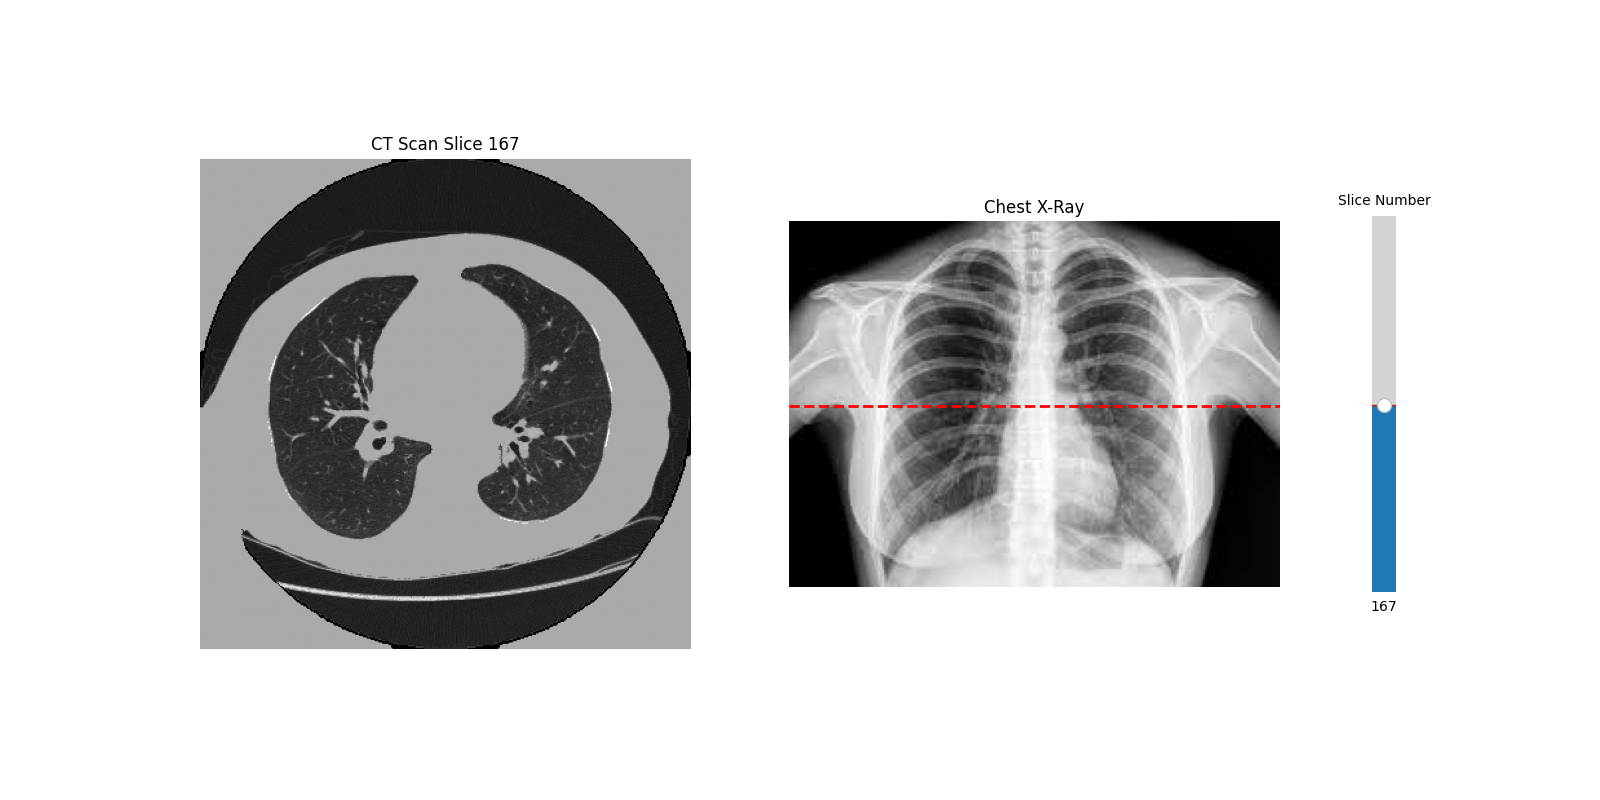

In [49]:
if __name__ == "__main__":
    mask = isolate_lung(newImage)

    segmentedVolume = newImage * mask
    visualize_image(segmentedVolume)

In [50]:
if __name__ == "__main__":
    print(segmentedVolume.shape)

(335, 380, 380)


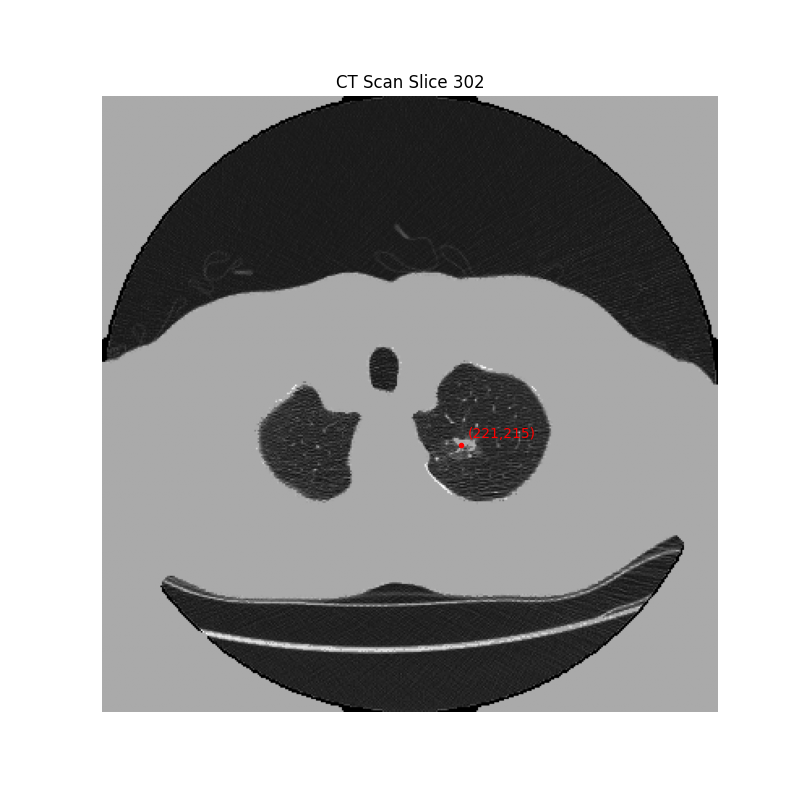

In [51]:
visualize_single_slice(segmentedVolume, "After lung segmentation", 302, 221, 215)

In [52]:
def Min_Max_scaling(numpyImage):
    normalized_image = (numpyImage - (-1000)) / (400 - (-1000))

    return normalized_image

In [53]:
if __name__ == "__main__":
    normalizedVolume =  Min_Max_scaling(segmentedVolume)

In [54]:
if __name__ == "__main__":
    print("image shape after normalization:", normalizedVolume.shape)

image shape after normalization: (335, 380, 380)


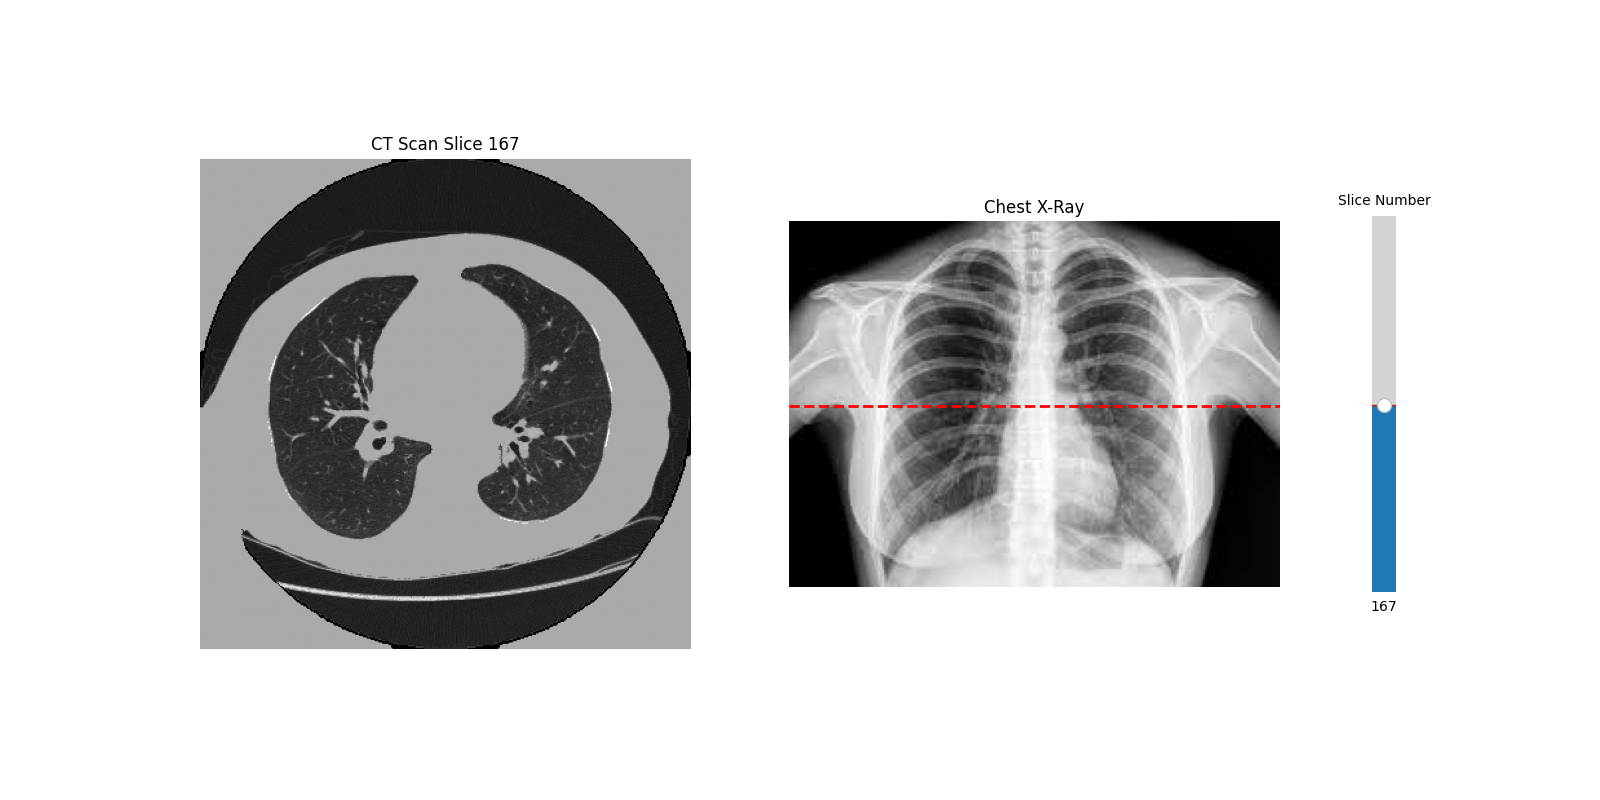

In [55]:
if __name__ == "__main__":
    visualize_image(normalizedVolume)

In [56]:
def crop_image(volume, crop_shape):
    """
    Crop a 3D volume to the desired crop_shape from the center.
    
    Parameters:
        volume (np.ndarray): 3D numpy array to crop.
        crop_shape (tuple): Desired output shape (depth, height, width).
        
    Returns:
        np.ndarray: Cropped volume.
    """
    z, y, x = volume.shape
    cz, cy, cx = crop_shape

    start_z = (z - cz) // 2
    start_y = (y - cy) // 2
    start_x = (x - cx) // 2

    end_z = start_z + cz
    end_y = start_y + cy
    end_x = start_x + cx

    return volume[start_z:end_z, start_y:end_y, start_x:end_x]

In [57]:
if __name__ == "__main__":
    croppedVolume = crop_image(normalizedVolume, (300, 300, 300))

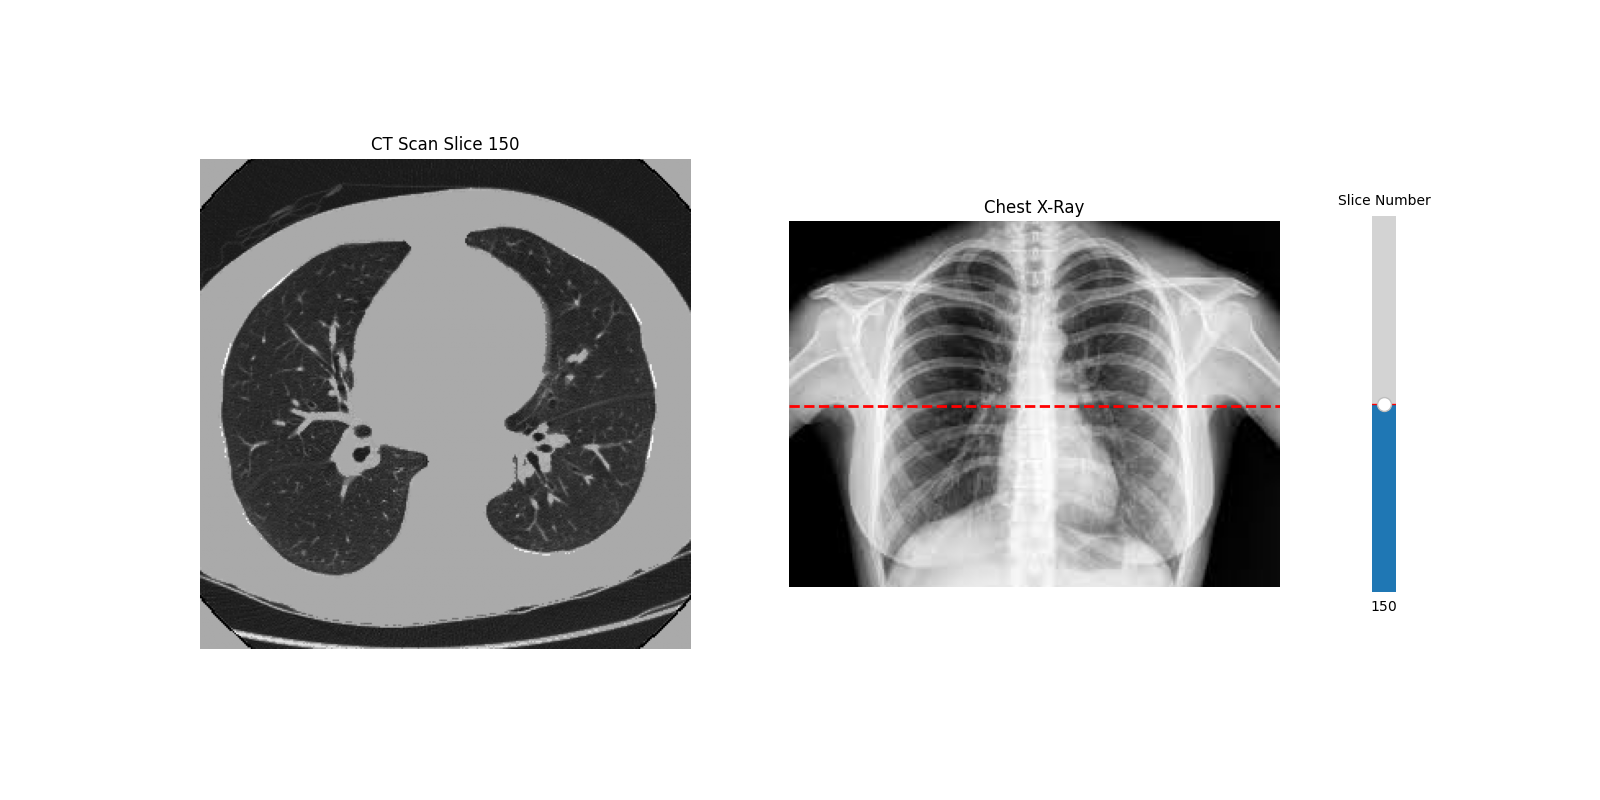

In [58]:
if __name__ == "__main__":
    visualize_image(croppedVolume)

In [59]:
def get_metadata(file_path):
    """
    Get shape, spacing, and origin of a medical image (e.g., .mhd, .nii, .nrrd).
    
    Args:
        file_path (str): Path to the image file.
        
    Returns:
        tuple: (shape, spacing, origin)
            - shape: (Depth, Height, Width) in voxels.
            - spacing: (Depth_spacing, Height_spacing, Width_spacing) in mm.
            - origin: (Depth_origin, Height_origin, Width_origin) in mm (world coordinates).
    """
    img = sitk.ReadImage(file_path)  # Metadata-only (fast)
    
    # Get metadata (reversed to match ZYX order)
    shape = list(reversed(img.GetSize()))      # (Depth, Height, Width)
    spacing = list(reversed(img.GetSpacing())) # (Depth_spacing, Height_spacing, Width_spacing)
    origin = list(reversed(img.GetOrigin()))   # (Depth_origin, Height_origin, Width_origin)
    
    return shape, spacing, origin

In [60]:
# if __name__ == "__main__":
#     CT_data = pd.read_csv("Data/Luna/CT_scans_data.csv")

In [61]:
# if __name__ == "__main__":
#     CT_shapes = CT_data[["Subset", "CT-number", "Filename", "File Path"]].copy()
#     CT_shapes["shape"] = None
    

In [62]:
def calculate_new_shape(numpyImage_shape, numpySpacing, target_spacing=[1.0, 1.0, 1.0]):
    """
    Args:
        numpyImage_shape: Shape of the input image (Z, Y, X).
        numpySpacing: Current spacing (Z_sp, Y_sp, X_sp).
        target_spacing: Desired spacing (default: [1.0, 1.0, 1.0] mm).
    
    Returns:
        new_shape: Resampled shape (Z, Y, X) after accounting for spacing change.
        resize_factor: Scaling factor for each axis (Z, Y, X).
    """
    # Ensure inputs are numpy arrays
    numpySpacing = np.array(numpySpacing)
    target_spacing = np.array(target_spacing)
    
    # Calculate resize factor (per-axis scaling)
    resize_factor = numpySpacing / target_spacing  # (Z_scale, Y_scale, X_scale)
    
    # Compute new shape (rounded to nearest integer)
    new_real_shape = np.array(numpyImage_shape) * resize_factor
    new_shape = np.round(new_real_shape).astype(int)
    
    return new_shape

In [63]:
# def get_ct_shape(row):
#     # For example, use the file path to load the volume and get its shape
#     print(row["File Path"])
#     path = row["File Path"]
#     shape, spacing, origin = get_metadata(path)
    
#     newShape = calculate_new_shape(shape, spacing)
    
#     return newShape

In [64]:
# if __name__ == "__main__":
#     CT_shapes["shape"] = CT_shapes.apply(get_ct_shape, axis=1)

In [65]:
# CT_shapes

In [66]:
# CT_shapes[['Z', 'Y', 'X']] = pd.DataFrame(CT_shapes['shape'].tolist(), index=CT_shapes.index)

In [67]:
# CT_shapes.to_csv("Data/Luna/ct_shapes.csv", index=False)

In [68]:
CT_shapes = pd.read_csv("Data/Luna/ct_shapes.csv")

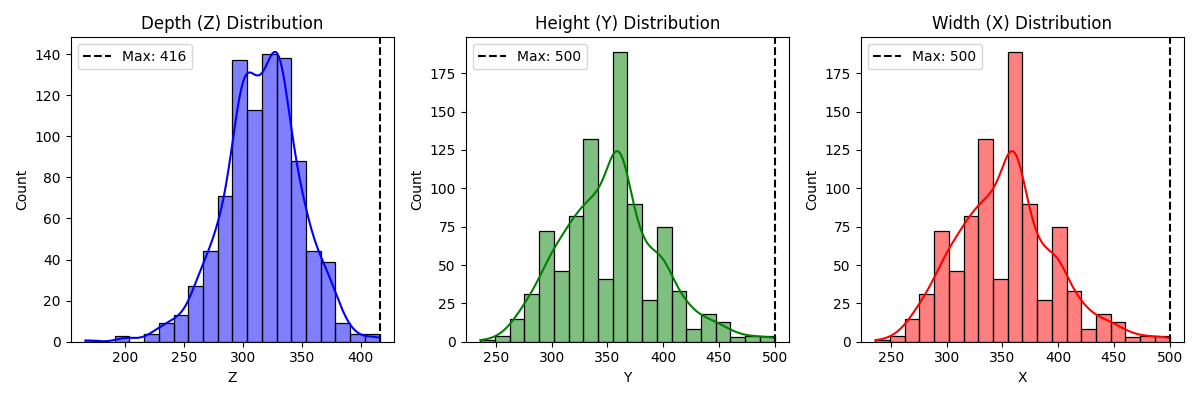

In [69]:
if __name__ == "__main__":
    plt.figure(figsize=(12, 4))

    # Get max values for each dimension
    max_z = CT_shapes['Z'].max()
    max_y = CT_shapes['Y'].max()
    max_x = CT_shapes['X'].max()

    # ------ Plot 1: Depth (Z) ------
    plt.subplot(1, 3, 1)
    sns.histplot(CT_shapes['Z'], bins=20, kde=True, color='blue')
    plt.axvline(max_z, color='black', linestyle='--', linewidth=1.5, label=f'Max: {max_z}')
    plt.title('Depth (Z) Distribution')
    plt.legend()

    # ------ Plot 2: Height (Y) ------
    plt.subplot(1, 3, 2)
    sns.histplot(CT_shapes['Y'], bins=20, kde=True, color='green')
    plt.axvline(max_y, color='black', linestyle='--', linewidth=1.5, label=f'Max: {max_y}')
    plt.title('Height (Y) Distribution')
    plt.legend()

    # ------ Plot 3: Width (X) ------
    plt.subplot(1, 3, 3)
    sns.histplot(CT_shapes['X'], bins=20, kde=True, color='red')
    plt.axvline(max_x, color='black', linestyle='--', linewidth=1.5, label=f'Max: {max_x}')
    plt.title('Width (X) Distribution')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [70]:
def load_paths(filename):
    data = pd.read_csv(filename)

    paths = {}

    for index, row in data.iterrows():
        paths[row["Filename"]] = row["File Path"]

    return paths
    

In [71]:
def add_voxel_coord(annotations_subset, origin, spacing):
    """Convert real-world coordinates to voxel coordinates for a subset of annotations."""
    subset = annotations_subset.copy()
    subset["voxel_Z"] = np.round((subset["coordZ"] - origin[0]) / spacing[0]).astype(int)
    subset["voxel_Y"] = np.round((subset["coordY"] - origin[1]) / spacing[1]).astype(int)
    subset["voxel_X"] = np.round((subset["coordX"] - origin[2]) / spacing[2]).astype(int)
    return subset

In [72]:
def process_all_annotations(annotations_df, seriesuid_to_path):
    """
    Process all annotations in the DataFrame to add voxel coordinates.
    
    Args:
        annotations_df (pd.DataFrame): DataFrame with columns: seriesuid, coordX, coordY, coordZ.
        seriesuid_to_path (dict): Maps seriesuid to CT scan file paths.
        
    Returns:
        pd.DataFrame: Annotations with added voxel coordinates (voxel_X, voxel_Y, voxel_Z).
    """
    results = []
    for seriesuid, group in annotations_df.groupby("seriesuid"):
        if seriesuid in seriesuid_to_path:
            file_path = seriesuid_to_path[seriesuid]
            shape, spacing, origin = get_metadata(file_path)
            subset_with_voxel = add_voxel_coord(group, origin, spacing)
            results.append(subset_with_voxel)
        else:
            print(f"Warning: seriesuid {seriesuid} not found in path dictionary. Skipping.")
    
    return pd.concat(results, ignore_index=True)

In [73]:
if __name__ == "__main__":
    paths_dict = load_paths("Data/Luna/CT_scans_data.csv")

In [74]:
# if __name__ == "__main__":
#     annotations_with_voxel = process_all_annotations(annotations, paths_dict)

### Candidates:

In [75]:
if __name__ == "__main__":
    candidates = load_csv("candidates_V2.csv")
    print(candidates)

                                                seriesuid     coordX  \
0       .3.6.1.4.1.14519.5.2.1.6279.6001.1002252872223...  68.420000   
1       1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222... -95.209361   
2       1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222... -24.766755   
3       1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222... -63.080000   
4       1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...  52.946688   
...                                                   ...        ...   
754970  1.3.6.1.4.1.14519.5.2.1.6279.6001.997611074084... -33.400000   
754971  1.3.6.1.4.1.14519.5.2.1.6279.6001.997611074084...  56.236359   
754972  1.3.6.1.4.1.14519.5.2.1.6279.6001.997611074084... -97.104221   
754973  1.3.6.1.4.1.14519.5.2.1.6279.6001.997611074084... -65.470000   
754974  1.3.6.1.4.1.14519.5.2.1.6279.6001.997611074084...  -3.100000   

            coordY      coordZ  class  
0       -74.480000 -288.700000      0  
1       -91.809406 -377.426350      0  
2      -120.379

In [76]:
def compare_classes(df):
    class_counts = df["class"].value_counts()
    print(class_counts)

    # Plot the bar chart
    plt.figure(figsize=(6, 4))
    class_counts.plot(kind="bar", color=["blue", "red"])
    plt.xlabel("Class")
    plt.ylabel("Count")
    plt.title("Number of Individuals in Each Class")
    plt.xticks(ticks=[0, 1], labels=["Class 0", "Class 1"], rotation=0)
    plt.grid(axis="y", linestyle="--", alpha=0.7)

    plt.savefig('Data_vis/Luna/candidates_class_imbalance', dpi=300, bbox_inches='tight')

    # Show the plot
    plt.show()

class
0    753417
1      1558
Name: count, dtype: int64


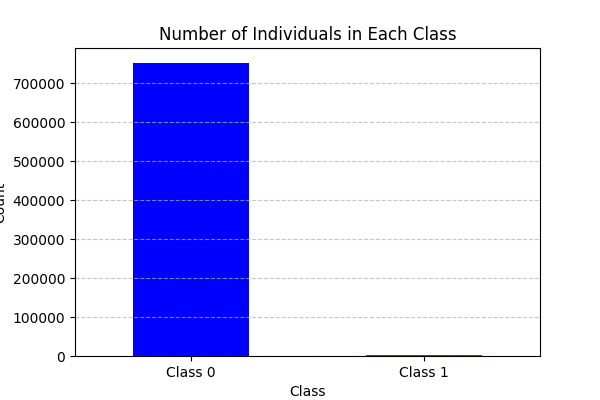

In [77]:
if __name__ == "__main__":
    compare_classes(candidates)

## Feature engineering

### Generate full paths for all the CT-scans:

In [78]:
# print(len(Data))
# print(Data.keys())
# Data.pop("subset10")
# print(Data.keys())

In [79]:
# if __name__ == "__main__":
#     # Generate a new dataframe that have all the CT-scans
#     Columns = ["Subset", "CT-number", "Filename"]
#     CT_scans_df = pd.DataFrame(columns=Columns)

#     for key, value in Data.items():
#         for key_, value_ in value.items():
#             CT_scans_df.loc[CT_scans_df.shape[0]] = {"Subset": key, "CT-number": key_, "Filename": value_}

#     # Calculate the number of FP and TP for each scan
#     class_counts_per_uid = candidates.groupby('seriesuid')['class'].value_counts().unstack(fill_value=0)

#     # Add the number of FP and TP to the dataframe
#     for index, row in CT_scans_df.iterrows():
#         uid = row["Filename"].removesuffix(".mhd")  # Extract the series UID
#         class_0 = class_counts_per_uid.loc[uid, 0]  # Get the class 0 count
#         class_1 = class_counts_per_uid.loc[uid, 1]
#         CT_scans_df.loc[index, "False positive"] = class_0  # Use loc to modify the DataFrame safely
#         CT_scans_df.loc[index, "True positive"] = class_1

#     # Add the full path to each scan
#     for index, row in CT_scans_df.iterrows():
#         path = f"Data/Luna/{row['Subset']}/{row['Filename']}"
#         CT_scans_df.loc[index, "File Path"] = path

#     for index, row in CT_scans_df.iterrows():
#         seriesuid = row["Filename"].removesuffix(".mhd")
#         row["Filename"] = seriesuid
#         CT_scans_df.loc[index, "Filename"] = seriesuid


In [80]:
# CT_scans_df["Filename"].iloc[1]

In [81]:
# if __name__ == "__main__":
#     CT_scans_df.to_csv('Data/Luna/CT_scans_data.csv', index=False)


In [82]:
# if __name__ == "__main__":
#     annotations_bbox = annotations.copy()

#     for index, row in annotations_bbox.iterrows():
#         bbox_x = row["coordX"] - (row["diameter_mm"] / 2)
#         bbox_y = row["coordY"] - (row["diameter_mm"] / 2)
#         bbox_z = row["coordZ"] - (row["diameter_mm"] / 2)

#         annotations_bbox.loc[index, "bbox_x"] = bbox_x
#         annotations_bbox.loc[index, "bbox_y"] = bbox_y
#         annotations_bbox.loc[index, "bbox_z"] = bbox_z

In [83]:
# if __name__ == "__main__":
#     annotations_bbox.to_csv('Data/Luna/annotations_bbox.csv', index=False)

In [84]:
def extract_patch(ct_scan, center, patch_size):
        """Extracts a 3D patch centered around `center` with handling for out-of-bounds."""
        x, y, z = center
        ph, pw, pd = np.array(patch_size) // 2

        # Calculate slice indices with boundary checks
        x_start = max(0, x - ph)
        x_end = min(ct_scan.shape[0], x + ph + (1 if patch_size[0] % 2 else 0))
        y_start = max(0, y - pw)
        y_end = min(ct_scan.shape[1], y + pw + (1 if patch_size[1] % 2 else 0))
        z_start = max(0, z - pd)
        z_end = min(ct_scan.shape[2], z + pd + (1 if patch_size[2] % 2 else 0))

        # Extract the patch
        patch = ct_scan[z_start:z_end, x_start:x_end, y_start:y_end]

        # Pad the patch if it's smaller than the target size
        return patch

In [85]:
patch = extract_patch(segmentedVolume, (221, 215, 302), (64, 64, 64))

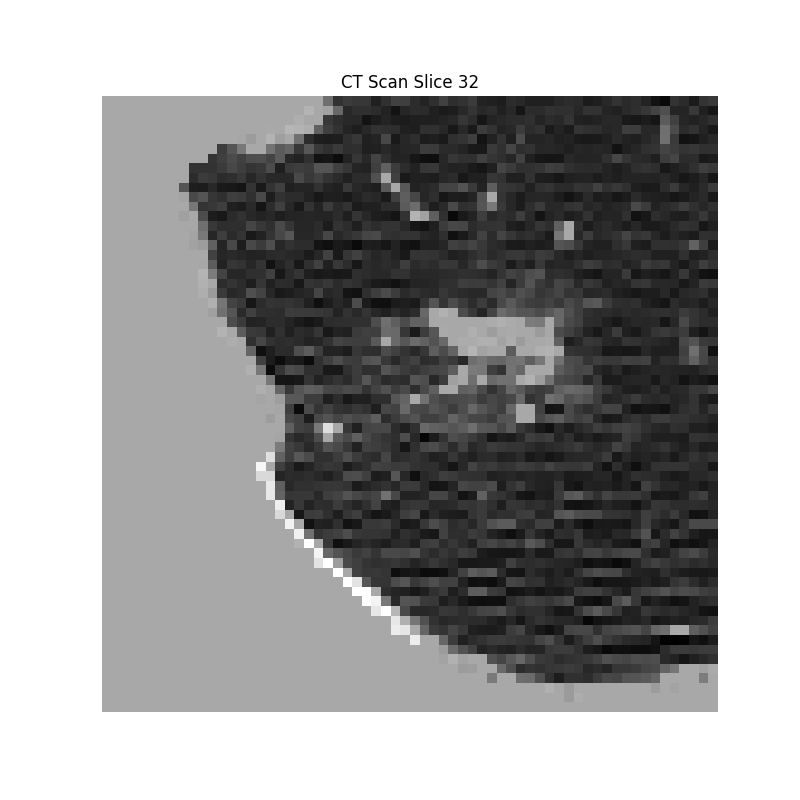

In [86]:
visualize_single_slice(patch, "Nodule patch", 32)

In [87]:
def sliding_window_crop(ct_scan, center, patch_size):
    patch1 = extract_patch(ct_scan, (center[0] - 10, center[1] - 10, center[2] - 10), patch_size)
    patch2 = extract_patch(ct_scan, (center[0] + 10, center[1] + 10, center[2] + 10), patch_size)
    patch3 = extract_patch(ct_scan, (center[0] - 10, center[1], center[2]), patch_size)
    patch4 = extract_patch(ct_scan, (center[0] + 10, center[1], center[2]), patch_size)
    patch5 = extract_patch(ct_scan, (center[0], center[1] - 10, center[2]), patch_size)
    patch6 = extract_patch(ct_scan, (center[0], center[1] + 10, center[2]), patch_size)
    patch7 = extract_patch(ct_scan, (center[0], center[1], center[2] - 10), patch_size)
    patch8 = extract_patch(ct_scan, (center[0], center[1], center[2] + 10), patch_size)

    patches = (patch1, patch2, patch3, patch4, patch5, patch6, patch7, patch8)

    return patches

In [88]:
if __name__ == "__main__":
    swc_patches = sliding_window_crop(segmentedVolume, (221, 215, 302), (64, 64, 64))

In [89]:
def visualize_middle_slices(volume_images, plot_name, grid_shape=None):
    """
    Visualizes the middle slice of each 3D volume image in a grid-style plot.
    
    Parameters:
        volume_images (list of ndarray): List of 3D volume data.
        plot_name (str): Name of the output plot file.
        grid_shape (tuple, optional): Shape of the grid (rows, cols). If None, it will be automatically determined.
    """
    num_images = len(volume_images)
    
    # Determine the grid shape if not provided
    if grid_shape is None:
        grid_rows = int(np.ceil(np.sqrt(num_images)))
        grid_cols = int(np.ceil(num_images / grid_rows))
    else:
        grid_rows, grid_cols = grid_shape
    
    # Create the figure and subplots
    fig, axes = plt.subplots(grid_rows, grid_cols, figsize=(10, 10))
    
    # Flatten the axes array for easy iteration
    axes = axes.ravel()
    
    # Loop through each volume image and plot the middle slice
    for i, volume in enumerate(volume_images):
        # Calculate the middle slice index
        middle_slice = volume.shape[0] // 2
        
        # Display the middle slice in grayscale
        axes[i].imshow(volume[middle_slice], cmap="gray")
        axes[i].set_title(f"Slice {middle_slice}")
        axes[i].axis("off")
    
    # Hide any unused subplots
    for j in range(i + 1, grid_rows * grid_cols):
        axes[j].axis("off")
    
    # Adjust layout and save the plot
    plt.tight_layout()
    plt.savefig(f'Data_vis/Luna/{plot_name}', dpi=300, bbox_inches='tight')
    plt.show()


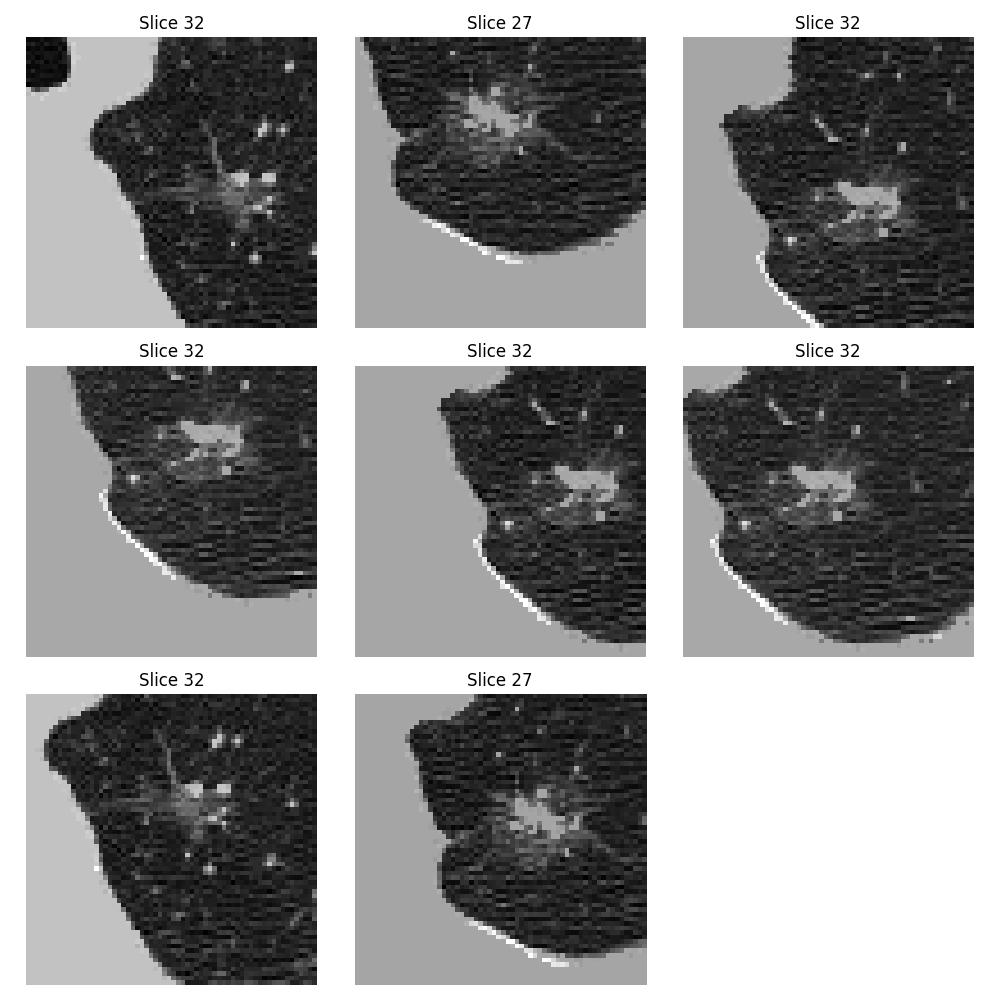

In [90]:
if __name__ == "__main__":
    visualize_middle_slices(swc_patches, "sliding window result")

In [91]:
def flip_patch_3d(patch):
    """
    Flips a 3D patch around the x-axis, y-axis, and z-axis.

    Args:
        patch (numpy.ndarray): A 3D patch of shape (depth, height, width).

    Returns:
        tuple: A tuple containing the patch flipped along the x-axis, y-axis, and z-axis.
    """
    # Flip along the x-axis (depth)
    flip_x = np.flip(patch, axis=0)

    # Flip along the y-axis (height)
    flip_y = np.flip(patch, axis=1)

    # Flip along the z-axis (width)
    flip_z = np.flip(patch, axis=2)

    return flip_x, flip_y, flip_z

In [92]:
if __name__ == "__main__":
    flip_patches = flip_patch_3d(patch)

C:\Users\Ibrahim\AppData\Local\Temp\ipykernel_9396\1153615695.py:20: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axes = plt.subplots(grid_rows, grid_cols, figsize=(10, 10))


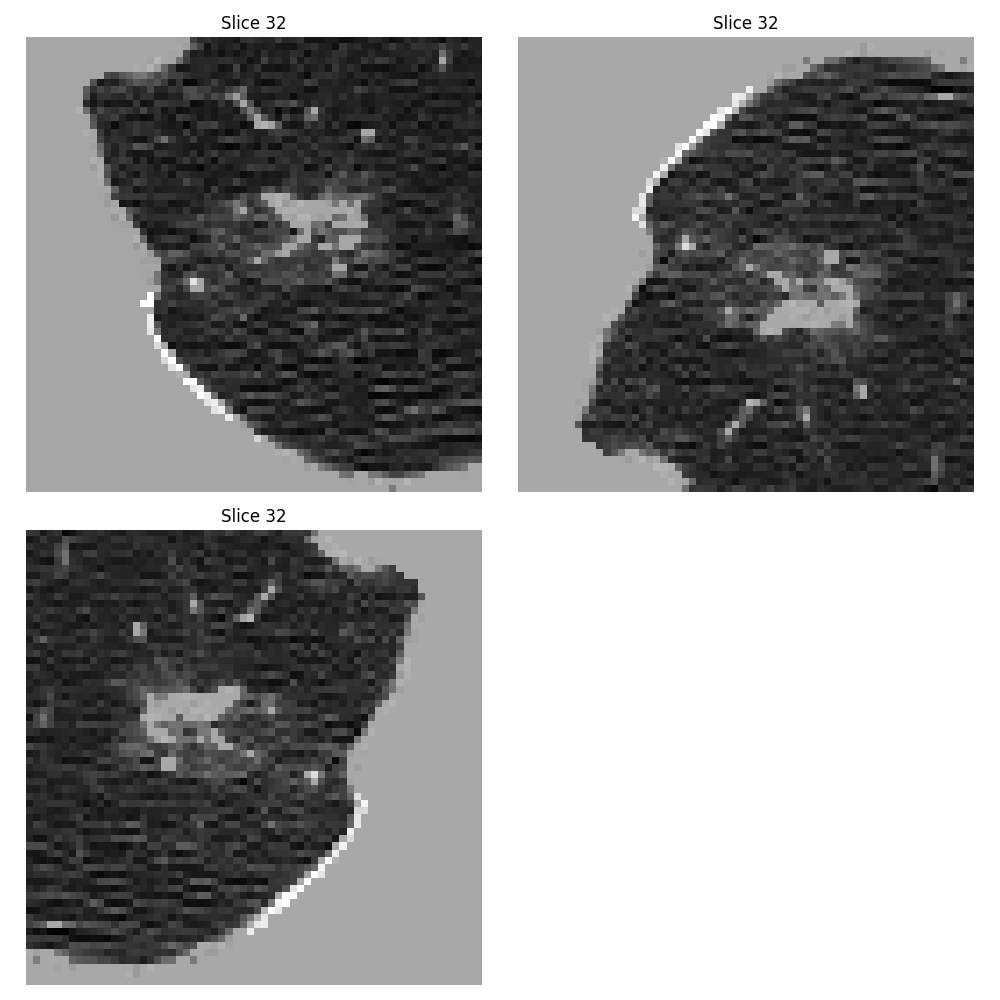

In [93]:
if __name__ == "__main__":
    visualize_middle_slices(flip_patches, "flipping method")

In [94]:
def rotate_patch_3d(patch):
    """
    Rotates a 3D patch by 90°, 180°, and 270° in the plane of the last two axes (height and width).

    Args:
        patch (numpy.ndarray): A 3D patch of shape (depth, height, width).

    Returns:
        tuple: A tuple containing the patch rotated by 90°, 180°, and 270°.
    """
    # Rotate 90° (counterclockwise in the plane of the last two axes)
    rotate_90 = np.rot90(patch, k=1, axes=(1, 2))

    # Rotate 180°
    rotate_180 = np.rot90(patch, k=2, axes=(1, 2))

    # Rotate 270° (equivalent to rotating 90° clockwise)
    rotate_270 = np.rot90(patch, k=3, axes=(1, 2))

    return rotate_90, rotate_180, rotate_270

In [95]:
if __name__ == "__main__":
    rotate_patches = rotate_patch_3d(patch)

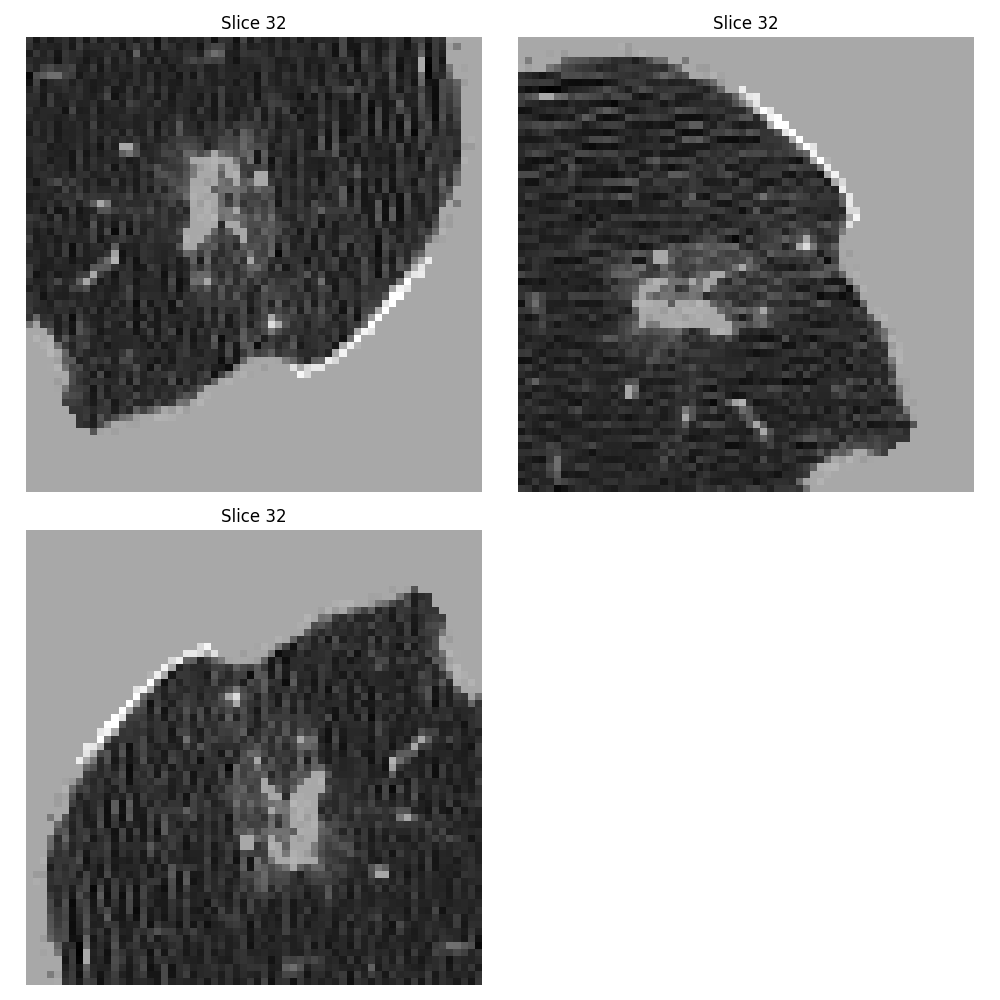

In [96]:
if __name__ == "__main__":
    visualize_middle_slices(rotate_patches, "Rotation method method")

### Calculate Bounding Boxes for the annotations:

### Data Generator:

## CT-scans generator:

In [123]:
# Load the first CSV file (containing shape, Z, Y, X)
df1 = pd.read_csv('Data/Luna/ct_shapes.csv')  # Replace with the path to your first CSV

# Load the second CSV file (containing False positive, True positive, etc.)
df2 = pd.read_csv('Data/Luna/CT_scans_data.csv')  # Replace with the path to your second CSV

# Merge df1 and df2 based on the 'Filename' column
df_merged = pd.merge(df2, df1[['Filename', 'shape', 'Z', 'Y', 'X']], on='Filename', how='left')

# Save the resulting DataFrame to a new CSV file
df_merged.to_csv('Data/Luna/CT_scans.csv', index=False) 

In [ ]:
class CT_scansGenerator(Sequence):
    def __init__(self, ct_scans, annotations, ct_shapes, batch_size, patch_size=(128, 128, 128), shuffle=True, stride=None):
        """
        Initializes the generator for 3D nodule detection.

        Parameters:
        - ct_scans: Dictionary or CSV of scan paths (seriesuid → path)
The code you provided is creating two instances of the `CT_scansGenerator` class - `val_generator` and `test_generator`.
        - annotations: CSV file with voxel coordinates of nodule centers
        - ct_shapes: CSV with original CT shape info
        - batch_size: How many patches per batch
        - patch_size: Size of 3D input patch
        - shuffle: Whether to shuffle patch list after every epoch
        - stride: How far to slide the patch (default: half patch size)
        """
        self.ct_scans = load_paths(ct_scans)  # Load seriesuid → file path map
        self.annotations = pd.read_csv(annotations)
        self.ct_shapes = pd.read_csv(ct_shapes)
        self.batch_size = batch_size
        self.patch_size = np.array(patch_size)
        self.shuffle = shuffle
        self.stride = stride if stride is not None else self.patch_size // 2
        
        print(type(self.ct_scans))
        print(len(list(self.ct_scans.keys())))
        
        self.ct_shapes['shape_array'] = self.ct_shapes['shape'].apply(
            lambda x: np.array(eval(x.replace(' ', ',') if isinstance(x, str) else x))
        )

        self.filename_to_idx = {fn: i for i, fn in enumerate(self.ct_shapes['Filename'])}
        self.patch_info = self._precompute_patches()
        self.indices = np.arange(len(self.patch_info))

        if self.shuffle:
            np.random.shuffle(self.indices)

    def _precompute_patches(self):
        """
        Create all patch positions (z, y, x) for every scan and mark whether they contain a nodule.
        """
        patch_info = []

        for scan_idx, row in self.ct_shapes.iterrows():
            scan_filename = row['Filename']
            scan_shape = row['shape_array']

            # Get voxel-space annotations for this scan
            voxel_coords = self.annotations[self.annotations['seriesuid'] == scan_filename][['voxel_Z', 'voxel_Y', 'voxel_X']].values

            # Compute how many patches in each direction
            n_patches = [(scan_shape[i] - self.patch_size[i]) // self.stride[i] + 1 for i in range(3)]

            for z in range(n_patches[0]):
                for y in range(n_patches[1]):
                    for x in range(n_patches[2]):
                        z_pos = z * self.stride[0]
                        y_pos = y * self.stride[1]
                        x_pos = x * self.stride[2]

                        # Check if patch contains a center
                        centers = self._get_nodule_centers_in_patch(voxel_coords, z_pos, y_pos, x_pos)
                        patch_info.append({
                            'scan_idx': scan_idx,
                            'position': (z_pos, y_pos, x_pos),
                            'nodule_centers': centers
                        })

        return patch_info

    def _get_nodule_centers_in_patch(self, voxel_coords, z, y, x):
        """
        Return relative nodule center(s) inside this patch, or empty list.
        """
        centers = []
        for (nz, ny, nx) in voxel_coords:
            if z <= nz < z + self.patch_size[0] and y <= ny < y + self.patch_size[1] and x <= nx < x + self.patch_size[2]:
                centers.append((nz - z, ny - y, nx - x))  # Relative to patch center
                # add an empty list if patch doesn't contain a nodule center
        return centers

    def __len__(self):
        return int(np.ceil(len(self.patch_info) / self.batch_size))

    def __getitem__(self, index):
        """
        Returns a batch of data.
        """
        batch_indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]

        X = np.zeros((len(batch_indices), *self.patch_size, 1), dtype=np.float32)
        y = np.full((len(batch_indices), 3), -1.0, dtype=np.float32)  # Center coords or (-1, -1, -1) if no center

        ct_scan_cache = {}

        for i, idx in enumerate(batch_indices):
            patch = self.patch_info[idx]
            scan_idx = patch['scan_idx']
            z, y_pos, x = patch['position']
            scan_id = self.ct_shapes.iloc[scan_idx]["Filename"]
            scan_path = self.ct_scans[scan_id]

            # Load scan if not cached
            if scan_path in ct_scan_cache:
                scan = ct_scan_cache[scan_path]
            else:
                scan, origin, spacing = load_itk_image(scan_path)
                
                # resizing the image
                scan, newOrignn, newSpacing, resizedAnn = resize_image_with_annotation(scan_idx, scan, origin, spacing, self.annotations)
                
                scan = clip_CT_scan(scan)  # Apply HU clipping
                scan = isolate_lung(scan) * scan  # Apply segmentation mask
                scan = Min_Max_scaling(scan)  # Normalize
                ct_scan_cache[scan_path] = scan

            # Extract patch from 3D scan
            patch_volume = scan[z:z+self.patch_size[0], y_pos:y_pos+self.patch_size[1], x:x+self.patch_size[2]]

            # Add channel dimension and store
            X[i, ..., 0] = patch_volume

            # Assign target: center coord or (-1, -1, -1)
            if patch['nodule_centers']:
                # If multiple centers, pick first or average — up to you
                center = patch['nodule_centers'][0]  # You can average instead if needed
                y[i] = center
            else:
                y[i] = (-1, -1, -1)

        return X, y

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)

In [101]:
# if __name__ == "__main__":
#     generator_detection = CT_scansGenerator(
#         ct_scans = "Data/Luna/CT_scans_data.csv",
#         annotations = "Data/Luna/annotations_with_voxel.csv",
#         ct_shapes = "Data/Luna/ct_shapes.csv",
#         batch_size = 8,
#     )

In [102]:
# if __name__ == "__main__":
#     batch_data, batch_labels = generator_detection[2]

In [103]:
# if __name__ == "__main__":
# # Fetch the first batch
#     X, y = generator_detection[0]

#     # Visualize the first 3D patch (remove channel dimension)
#     visualize_image(X[0, ..., 0])

#     # Optionally print the corresponding label (nodule center or -1s)
#     print("Nodule center (relative to patch):", y[0])

In [104]:
# if __name__ == "__main__":    
#     # Check shapes
#     print(f"Batch data shape: {batch_data.shape}")  # Should be (batch_size, 128, 128, 128, 1)
#     print(f"Batch labels shape: {batch_labels.shape}")  # Should be (batch_size,)

#     # Verify labels
#     print("Unique labels in batch:", np.unique(batch_labels))

In [137]:
def conv_block(x, filters, kernel_size=3, strides=1):
    x = layers.Conv3D(filters, kernel_size, strides=strides, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    return x

def residual_block(x, filters):
    shortcut = x
    x = conv_block(x, filters)
    x = conv_block(x, filters)
    x = layers.Add()([x, shortcut])
    x = layers.Activation('relu')(x)
    return x

def build_deep_3d_regression_model(input_shape=(128, 128, 128, 1)):
    inputs = tf.keras.Input(shape=input_shape)
    
    # Initial heavy downsampling
    x = conv_block(inputs, 16, strides=2)  # 64×64×64
    x = conv_block(x, 16)
    x = layers.MaxPooling3D(2)(x)  # 32×32×32
    
    # Intermediate layers
    x = conv_block(x, 32)
    x = residual_block(x, 32)
    x = layers.MaxPooling3D(2)(x)  # 16×16×16
    
    x = conv_block(x, 64)
    x = residual_block(x, 64)
    x = layers.MaxPooling3D(2)(x)  # 8×8×8
    
    # Final layers
    x = conv_block(x, 128)
    x = residual_block(x, 128)  # Keep 8×8×8
    
    x = layers.GlobalAveragePooling3D()(x)
    x = layers.Dense(64, activation='relu')(x)
    outputs = layers.Dense(3)(x)
    
    return models.Model(inputs, outputs)

In [106]:
# Custom loss (to ignore (-1, -1, -1) cases)

def masked_mse(y_true, y_pred):
    mask = tf.reduce_any(y_true >= 0, axis=-1, keepdims=True)
    diff = tf.where(mask, y_true - y_pred, tf.zeros_like(y_pred))
    return tf.reduce_mean(tf.square(diff))


In [135]:
train_generator = CT_scansGenerator(
        ct_scans = "Data/Luna/input/train.csv",
        annotations = "Data/Luna/annotations_with_voxel.csv",
        ct_shapes = "Data/Luna/input/train.csv",
        batch_size = 1,
    )

val_generator = CT_scansGenerator(
        ct_scans = "Data/Luna/input/val.csv",
        annotations = "Data/Luna/annotations_with_voxel.csv",
        ct_shapes = "Data/Luna/input/val.csv",
        batch_size = 1,
    )

test_generator = CT_scansGenerator(
        ct_scans = "Data/Luna/input/test.csv",
        annotations = "Data/Luna/annotations_with_voxel.csv",
        ct_shapes = "Data/Luna/input/test.csv",
        batch_size = 1,
    )

<class 'dict'>
621
<class 'dict'>
133
<class 'dict'>
134


In [108]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_loss',  # You can also monitor 'val_accuracy' or another metric
    patience=5,          # Number of epochs to wait for improvement before stopping
    restore_best_weights=True,  # Restore the model weights from the best epoch
    verbose=1            # To see when the early stopping is triggered
)



In [ ]:

faster_RCNN = build_deep_3d_regression_model()
faster_RCNN.compile(optimizer='adam', loss=masked_mse)

checkpoint_path = "Models/faster_rcnn.h5"  # Path to save the checkpoint

checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_path,  # Path to save the model
    save_weights_only=False,  # Save the entire model (architecture + weights + optimizer state)
    save_best_only=True,      # Save only the best model based on validation loss
    monitor='val_loss',       # Metric to monitor (e.g., validation loss)
    mode='min',              # Minimize the monitored metric
    verbose=1                # Print a message when saving the model
)

with tf.device('/GPU:0'):
    faster_RCNN.fit(
        train_generator,
        validation_data=val_generator,
        epochs=30,
        verbose=1,
        callbacks=[checkpoint_callback, early_stop]  # Add the early stop callback
    )

Epoch 1/30
   87/36027 [..............................] - ETA: 1257:33:35 - loss: 193.5450

In [125]:
df = pd.read_csv("Data/Luna/CT_scans.csv")  # or "annotations.csv"
series_col = 'Filename' if 'Filename' in df.columns else 'seriesuid'

In [126]:
# Get unique scan IDs
scan_ids = df[series_col].unique()

# First split: train vs temp (val+test)
train_ids, temp_ids = train_test_split(scan_ids, test_size=0.3, random_state=42)

# Second split: val vs test
val_ids, test_ids = train_test_split(temp_ids, test_size=0.5, random_state=42)


In [127]:
df_train = df[df[series_col].isin(train_ids)]
df_val   = df[df[series_col].isin(val_ids)]
df_test  = df[df[series_col].isin(test_ids)]


In [128]:
df_train.to_csv("Data/Luna/input/train.csv", index=False)
df_val.to_csv("Data/Luna/input/val.csv", index=False)
df_test.to_csv("Data/Luna/input/test.csv", index=False)

## Converting to pytorch:

In [102]:
class CTScansDataset(Dataset):
    def __init__(self, ct_scans, annotations, ct_shapes, patch_size=(128, 128, 128), stride=None, transform=None):
        """
        Dataset for 3D nodule detection.

        Parameters:
        - ct_scans: Dict or path to file with scan paths (seriesuid → path)
        - annotations: CSV with voxel coords of nodule centers
        - ct_shapes: CSV with CT shape info
        - patch_size: Size of 3D input patch
        - stride: Step size for sliding window (default = half patch size)
        - transform: Optional transform (for augmentations)
        """
        self.ct_scans = load_paths(ct_scans)
        self.annotations = pd.read_csv(annotations)
        self.ct_shapes = pd.read_csv(ct_shapes)
        self.patch_size = np.array(patch_size)
        self.stride = stride if stride is not None else self.patch_size // 2
        self.transform = transform

        self.ct_shapes['shape_array'] = self.ct_shapes['shape'].apply(
            lambda x: np.array(eval(x.replace(' ', ',') if isinstance(x, str) else x))
        )

        self.patch_info = self._precompute_patches()

    def _precompute_patches(self):
        patch_info = []

        for scan_idx, row in self.ct_shapes.iterrows():
            scan_filename = row['Filename']
            scan_shape = row['shape_array']

            # Get annotations for this scan
            voxel_coords = self.annotations[self.annotations['seriesuid'] == scan_filename][['voxel_Z', 'voxel_Y', 'voxel_X']].values
            n_patches = [(scan_shape[i] - self.patch_size[i]) // self.stride[i] + 1 for i in range(3)]

            for z in range(n_patches[0]):
                for y in range(n_patches[1]):
                    for x in range(n_patches[2]):
                        z_pos = z * self.stride[0]
                        y_pos = y * self.stride[1]
                        x_pos = x * self.stride[2]
                        centers = self._get_nodule_centers_in_patch(voxel_coords, z_pos, y_pos, x_pos)
                        patch_info.append({
                            'scan_idx': scan_idx,
                            'position': (z_pos, y_pos, x_pos),
                            'nodule_centers': centers
                        })

        return patch_info

    def _get_nodule_centers_in_patch(self, voxel_coords, z, y, x):
        centers = []
        for (nz, ny, nx) in voxel_coords:
            if z <= nz < z + self.patch_size[0] and y <= ny < y + self.patch_size[1] and x <= nx < x + self.patch_size[2]:
                centers.append((nz - z, ny - y, nx - x))  # relative coords
        return centers

    def __len__(self):
        return len(self.patch_info)

    def __getitem__(self, idx):
        patch = self.patch_info[idx]
        scan_idx = patch['scan_idx']
        z, y, x = patch['position']
        scan_id = self.ct_shapes.iloc[scan_idx]['Filename']
        scan_path = self.ct_scans[scan_id]

        # Load and preprocess CT
        scan, origin, spacing = load_itk_image(scan_path)
        scan, _, _, _ = resize_image_with_annotation(scan_idx, scan, origin, spacing, self.annotations)
        scan = clip_CT_scan(scan)
        scan = isolate_lung(scan) * scan
        scan = Min_Max_scaling(scan)

        # Extract patch
        patch_volume = scan[z:z+self.patch_size[0], y:y+self.patch_size[1], x:x+self.patch_size[2]]
        patch_volume = patch_volume[np.newaxis, ...]  # Add channel dim

        # Label: center coord or (-1, -1, -1)
        if patch['nodule_centers']:
            label = np.array(patch['nodule_centers'][0], dtype=np.float32)
        else:
            label = np.array([-1, -1, -1], dtype=np.float32)

        if self.transform:
            patch_volume = self.transform(patch_volume)

        return torch.tensor(patch_volume, dtype=torch.float32), torch.tensor(label, dtype=torch.float32)

In [103]:
# # Create the dataset
# ct_scans = "Data/Luna/CT_scans_data.csv"
# annotations = "Data/Luna/annotations_with_voxel.csv"
# ct_shapes = "Data/Luna/ct_shapes.csv"
# patch_size = (128, 128, 128)
# stride = (64, 64, 64)  # You can adjust this based on your patch overlap preference

# dataset = CTScansDataset(ct_scans, annotations, ct_shapes, patch_size=patch_size, stride=stride)

# # Create the DataLoader
# dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

# # Example: Iterate through the dataset
# patch, label = dataset[0]

# print("Patch shape:", patch.shape)  # Should be (1, 128, 128, 128)
# print("Label shape:", label.shape)  # Should be (3,)

# # Visualize it
# visualize_image(patch.squeeze(0).numpy())

In [104]:
def get_pretrained_resnet(model_depth=18, num_outputs=3):
    # Load model (use correct argument name)
    model = resnet.generate_model(
        model_depth=model_depth,
        n_input_channels=1,
        num_seg_classes=1000  # default from MedicalNet
    )

    # Load pretrained weights
    weight_path = f'Models/MedicalNet/pretrain/resnet_{model_depth}_23dataset.pth'
    checkpoint = torch.load(weight_path, map_location='cpu')
    model.load_state_dict(checkpoint['model'])

    # Replace final FC for regression (3 outputs for (z, y, x))
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, num_outputs)

    return model


In [105]:
def get_resnet_from_scratch(model_depth=18, num_outputs=3):
    # Load model with random initialization
    model = resnet.generate_model(
        model_depth=model_depth,
        n_input_channels=1,
        num_seg_classes=1000  # This value doesn't matter if you're replacing the FC layer
    )

    # Replace the final layer (conv_seg) with a Conv3d layer for 3 output values
    model.conv_seg[6] = nn.Conv3d(32, num_outputs, kernel_size=(1, 1, 1), stride=(1, 1, 1), bias=True)

    return model


In [106]:
gdown.download(
    'https://drive.google.com/uc?id=1DoDx_70_TLj98gTf6YTXnu4tFhsFocDX',
    'Models/MedicalNet/pretrain/resnet_18_23dataset.pth',
    quiet=False
)

Downloading...
From (original): https://drive.google.com/uc?id=1DoDx_70_TLj98gTf6YTXnu4tFhsFocDX
From (redirected): https://drive.google.com/uc?id=1DoDx_70_TLj98gTf6YTXnu4tFhsFocDX&confirm=t&uuid=db1eed0e-9b1b-4074-9b6f-ec78bec2bc71
To: d:\4DS7\PIDS\Models\MedicalNet\pretrain\resnet_18_23dataset.pth
100%|██████████| 111M/111M [06:58<00:00, 266kB/s]  


'Models/MedicalNet/pretrain/resnet_18_23dataset.pth'

In [107]:
if __name__ == "__main__":
    medicalNet_model = get_resnet_from_scratch(model_depth=18, num_outputs=3)

AttributeError: module 'Models.MedicalNet.models.resnet' has no attribute 'generate_model'

In [ ]:
dataset = CTScansDataset(ct_scans, annotations, ct_shapes)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True, num_workers=4)

In [ ]:
optimizer = optim.Adam(medicalNet_model.parameters(), lr=1e-4)  # You can adjust the learning rate
loss_fn = torch.nn.MSELoss()  # Assuming you're doing regression (coordinate prediction)

# Create a directory for saving checkpoints
checkpoint_dir = "Models/checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)

# Define the training function
def train(model, dataloader, optimizer, loss_fn, num_epochs=100, checkpoint_dir="Models/checkpoints"):
    model.train()  # Set the model to training mode

    for epoch in range(num_epochs):
        print(f"\n🔁 Epoch [{epoch+1}/{num_epochs}]")
        running_loss = 0.0
        
        for i, (inputs, targets) in enumerate(dataloader):
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_fn(outputs, targets)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            # Print debug info for every N batches
            if i % 10 == 0 or i == len(dataloader) - 1:
                print(f"  ▶ Batch [{i+1}/{len(dataloader)}], Loss: {loss.item():.4f}")
                print(f"     - Sample output: {outputs[0].detach().cpu().numpy()}")
                print(f"     - Target: {targets[0].detach().cpu().numpy()}")

        avg_loss = running_loss / len(dataloader)
        print(f"✅ Epoch [{epoch+1}/{num_epochs}] completed - Avg Loss: {avg_loss:.4f}")

        checkpoint_path = os.path.join(checkpoint_dir, f"checkpoint_epoch_{epoch+1}.pth")
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': avg_loss,
        }, checkpoint_path)
        print(f"💾 Checkpoint saved at {checkpoint_path}")

# Train the model
train(medicalNet_model, dataloader, optimizer, loss_fn, num_epochs=10, checkpoint_dir=checkpoint_dir)

## Candidates generator:

In [77]:
class NoduleCandidateGenerator(Sequence):
    def __init__(self, ct_scans, candidates_file, batch_size, patch_size=(64, 64, 64), shuffle=True):
        """
        Initializes the data generator.
        
        ct_scans: A csv file containg all CT scans and its corresponding paths.
        candidates_file: Path to the candidates CSV file containing coordinates and labels.
        batch_size: Number of samples per batch.
        patch_size: Size of the extracted 3D patches (default is 64x64x64).
        shuffle: Whether to shuffle the data after each epoch.
        """

        self.ct_scans = load_paths(ct_scans)
        self.candidates = pd.read_csv(candidates_file)  # Load the candidate annotations
        self.batch_size = batch_size
        self.patch_size = patch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(self.candidates)) # Creating an array of indexes the same size of candidates

        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __len__(self):
        """ Returns the number of batches per epoch """

        return int(np.floor(len(self.candidates) / self.batch_size))
    
    def __getitem__(self, index):
        """ Generates one batch of data """

        # Get the indices for this batch
        start_idx = index * self.batch_size
        end_idx = (index + 1) * self.batch_size
        batch_indices = self.indexes[start_idx:end_idx]
        batch_ct_scans = []
        batch_labels = []
        ct_scan_cache = {} # Cache CT scans loaded in this batch so that we don't have redandent loading

        for i in batch_indices:
            candidate = self.candidates.iloc[i]
            ct_scan_path = self.ct_scans[candidate["seriesuid"]]
            center_x, center_y, center_z = candidate["coordX"], candidate["coordY"], candidate["coordZ"]
            label = candidate["class"]

            # Load CT scan (use cached if already loaded in this batch)
            if ct_scan_path in ct_scan_cache:
                ct_scan = ct_scan_cache[ct_scan_path]
            else:
                ct_scan, numpyOrigin, numpySpacing = load_itk_image(ct_scan_path)
                ct_scan_cache[ct_scan_path] = ct_scan
            
            # Resampling
            ct_scan, newOrignn, newSpacing, resizedAnn = resize_image_with_annotation(candidate["seriesuid"], ct_scan, numpyOrigin, numpySpacing, candidate)
            
            center_x = resizedAnn["coordX"].iloc[0]
            center_y = resizedAnn["coordY"].iloc[0]
            center_z = resizedAnn["coordZ"].iloc[0]

            # Capping HU values between -1000 and 400
            ct_scan = clip_CT_scan(ct_scan)

            # Segmentation of lung region
            mask = isolate_lung(ct_scan)
            ct_scan = ct_scan * mask

            # Normilization
            ct_scan =  Min_Max_scaling(ct_scan)

            # Extract patch
            patch = self.extract_patch(ct_scan, (center_x, center_y, center_z), self.patch_size)
            batch_ct_scans.append(patch)
            batch_labels.append(label)

        # Debugging: Check shapes of patches
        for patch in batch_ct_scans:
            if patch.shape != self.patch_size:
                print(f"Warning: Patch shape {patch.shape} does not match expected {self.patch_size}")

        # Convert to numpy arrays and return
        return np.array(batch_ct_scans), np.array(batch_labels)
    
    def on_epoch_end(self):
        """ Shuffle data after each epoch """
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def extract_patch(self, ct_scan, center, patch_size):
        """Extracts a 3D patch centered around `center` with handling for out-of-bounds."""
        x, y, z = center
        ph, pw, pd = np.array(patch_size) // 2

        # Calculate slice indices with boundary checks
        x_start = max(0, x - ph)
        x_end = min(ct_scan.shape[0], x + ph + (1 if patch_size[0] % 2 else 0))
        y_start = max(0, y - pw)
        y_end = min(ct_scan.shape[1], y + pw + (1 if patch_size[1] % 2 else 0))
        z_start = max(0, z - pd)
        z_end = min(ct_scan.shape[2], z + pd + (1 if patch_size[2] % 2 else 0))

        # Extract the patch
        patch = ct_scan[x_start:x_end, y_start:y_end, z_start:z_end]

        # Pad the patch if it's smaller than the target size
        return self.pad_patch(patch, patch_size)
    
    def pad_patch(self, patch, target_size):
        """ Pads or crops the patch to match the target size. """
        # Ensure the patch has 3 dimensions
        if patch.ndim != 3:
            raise ValueError(f"Expected 3D patch, but got {patch.ndim}D input.")

        pad_dims = []
        crop_dims = []

        for dim in range(3):
            diff = target_size[dim] - patch.shape[dim]

            # Handle cases where the patch is smaller than the target size
            if diff > 0:
                pad_before = diff // 2
                pad_after = diff - pad_before
                pad_dims.append((pad_before, pad_after))
                crop_dims.append((0, patch.shape[dim]))  # No cropping needed
            # Handle cases where the patch is larger than the target size
            elif diff < 0:
                crop_before = (patch.shape[dim] - target_size[dim]) // 2
                crop_after = crop_before + target_size[dim]
                crop_dims.append((crop_before, crop_after))
                pad_dims.append((0, 0))  # No padding needed
            else:
                pad_dims.append((0, 0))
                crop_dims.append((0, patch.shape[dim]))  # No change needed

        # Crop the patch if necessary
        if any(crop[0] != 0 or crop[1] != patch.shape[dim] for dim, crop in enumerate(crop_dims)):
            patch = patch[
                crop_dims[0][0]:crop_dims[0][1],
                crop_dims[1][0]:crop_dims[1][1],
                crop_dims[2][0]:crop_dims[2][1]
            ]

        # Pad the patch if necessary
        if any(pad[0] != 0 or pad[1] != 0 for pad in pad_dims):
            patch = np.pad(patch, pad_dims, mode='constant', constant_values=0)

        return patch

In [78]:
if __name__ == "__main__":
    generator = NoduleCandidateGenerator(
        ct_scans = "Data/Luna/CT_scans_data.csv",
        candidates_file = "Data/Luna/candidates_V2.csv",
        batch_size = 1,
        patch_size = (64, 64, 64)
    )

In [79]:
if __name__ == "__main__":
    batch_data, batch_labels = generator[0]

In [80]:
if __name__ == "__main__":    
    # Check shapes
    print(f"Batch data shape: {batch_data.shape}")  # Should be (batch_size, 64, 64, 64, 1)
    print(f"Batch labels shape: {batch_labels.shape}")  # Should be (batch_size,)

    # Verify labels
    print("Unique labels in batch:", np.unique(batch_labels))

Batch data shape: (1, 64, 64, 64)
Batch labels shape: (1,)
Unique labels in batch: [0]


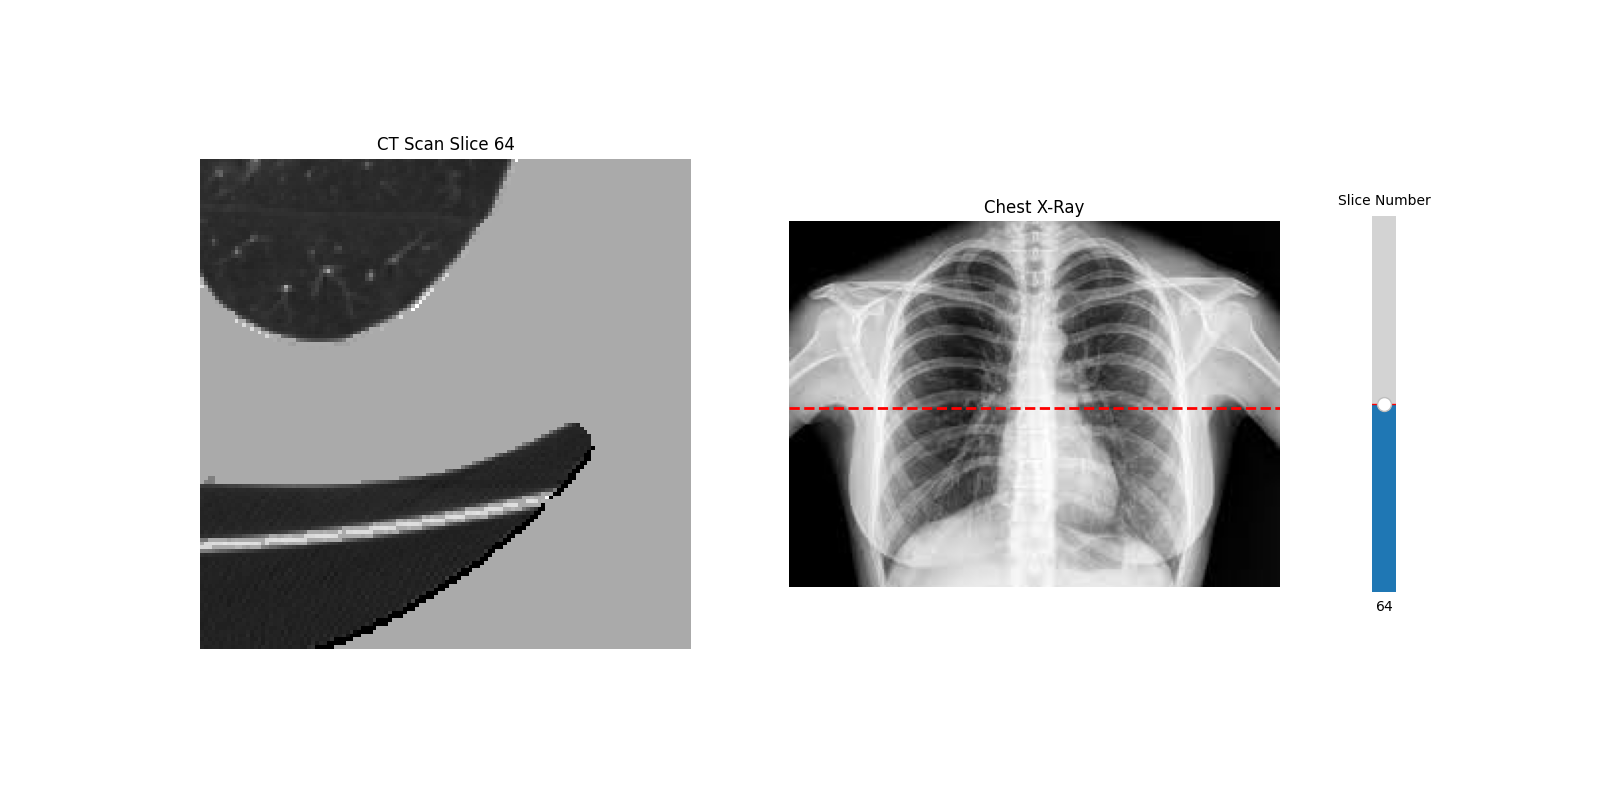

In [110]:
if __name__ == "__main__":
    visualize_image(batch_data[0])

## Creating a 3D CNN from scratch:

In [66]:
def build_3d_cnn(input_shape=(64, 64, 64, 1)):
    """Creates a 3D CNN for binary classification of lung nodules."""
    
    model = models.Sequential([
        # First 3D Convolutional Block
        layers.Conv3D(32, kernel_size=(3,3,3), activation='relu', padding='same', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.MaxPooling3D(pool_size=(2,2,2)),
        
        # Second 3D Convolutional Block
        layers.Conv3D(64, kernel_size=(3,3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling3D(pool_size=(2,2,2)),
        
        # Third 3D Convolutional Block
        layers.Conv3D(128, kernel_size=(3,3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling3D(pool_size=(2,2,2)),
        
        # Flatten & Fully Connected Layers
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.4),  # Regularization to prevent overfitting
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.4),
        
        # Output Layer (Binary Classification)
        layers.Dense(1, activation='sigmoid')  # Sigmoid for binary classification
    ])
    
    # Compile Model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                  loss='binary_crossentropy',  # Since it's a binary classification
                  metrics=['accuracy'])
    
    return model

checkpoint_path = "Models/3d_cnn_checkpoint.h5"  # Path to save the checkpoint
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_path,  # Path to save the model
    save_weights_only=False,  # Save the entire model (architecture + weights + optimizer state)
    save_best_only=True,      # Save only the best model based on validation loss
    monitor='val_loss',       # Metric to monitor (e.g., validation loss)
    mode='min',              # Minimize the monitored metric
    verbose=1                # Print a message when saving the model
)

In [67]:
if __name__ == "__main__":
    cnn_3d = build_3d_cnn()

In [68]:
if __name__ == "__main__":
    train_generator  = NoduleCandidateGenerator(
        ct_scans = "Data/Luna/CT_scans_data.csv",
        candidates_file = "Data/Luna/train_df.csv",
        batch_size = 1,
        patch_size = (64, 64, 64)
    )
    val_generator   = NoduleCandidateGenerator(
        ct_scans = "Data/Luna/CT_scans_data.csv",
        candidates_file = "Data/Luna/val_df.csv",
        batch_size = 1,
        patch_size = (64, 64, 64)
    )

In [69]:
if __name__ == "__main__":
    with tf.device('/GPU:0'):
        cnn_3d.fit(
            train_generator,
            validation_data=val_generator,
            epochs=30,
            verbose=1,
            callbacks=[checkpoint_callback]  # Add the checkpoint callback
        )

Epoch 1/30
3269/3269 [==============================] - ETA: 0s - loss: 2.4494 - accuracy: 0.5800 
Epoch 1: val_loss improved from inf to 0.65612, saving model to Models\3d_cnn_checkpoint.h5
3269/3269 [==============================] - 206463s 63s/step - loss: 2.4494 - accuracy: 0.5800 - val_loss: 0.6561 - val_accuracy: 0.6676
Epoch 2/30
  56/3269 [..............................] - ETA: 82:10:36 - loss: 0.7110 - accuracy: 0.6429

KeyboardInterrupt: 

In [111]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [110]:
# Detailed GPU info
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    details = tf.config.experimental.get_device_details(gpu)
    print(details)

{'device_name': 'NVIDIA GeForce GTX 1650', 'compute_capability': (7, 5)}


In [4]:
print(tf.test.is_built_with_cuda())  # Should print True
print(tf.config.experimental.list_physical_devices('GPU'))  # Should list your GPU
print(tf.test.gpu_device_name())  # Should print something like /device:GPU:0


True
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
/device:GPU:0
